In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models import resnet18


from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# Default device plus free memory
torch.cuda.empty_cache()
#device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
""" # Modify ResNet-18 for MNIST
model = resnet18(pretrained=False)
# Change the input layer to accept grayscale images
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# Adjust the final layer to output 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)

# Load the saved state_dict
model.load_state_dict(torch.load('./Models/resnet18_mnist.pth'))

# Move model to device and set to evaluation mode
model = model.to(device).eval() """

" # Modify ResNet-18 for MNIST\nmodel = resnet18(pretrained=False)\n# Change the input layer to accept grayscale images\nmodel.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\n# Adjust the final layer to output 10 classes\nmodel.fc = nn.Linear(model.fc.in_features, 10)\n\n# Load the saved state_dict\nmodel.load_state_dict(torch.load('./Models/resnet18_mnist.pth'))\n\n# Move model to device and set to evaluation mode\nmodel = model.to(device).eval() "

In [4]:
class Net(nn.Module):
    def __init__(self, chanels, kernel_size):
        super(Net, self).__init__()
        
        # First block
        self.conv1 = nn.Conv2d(1, chanels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(chanels)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        # Second block
        self.conv2 = nn.Conv2d(chanels, 2 * chanels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(2 * chanels)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        # Third block
        self.conv3 = nn.Conv2d(2*chanels, 4 * chanels, kernel_size, padding=kernel_size//2)
        self.bn3 = nn.BatchNorm2d(4 * chanels)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        
        # Fourth block (no pooling after this)
        self.conv4 = nn.Conv2d(4*chanels, 8 * chanels, kernel_size, padding=kernel_size//2)
        self.bn4 = nn.BatchNorm2d(8 * chanels)
        self.relu4 = nn.ReLU()
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(8*chanels, 128)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.relu4(self.bn4(self.conv4(x)))
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = self.drop1(F.relu(self.fc1(x)))
        x = self.fc2(x) 
        
        return x

In [5]:
# Instantiate the model
chanels = 32
kernel_size = 3
model = Net(chanels, kernel_size)

# Load the weights
model.load_state_dict(torch.load("./Models/custom_cnn_mnist.pth"))
model.eval()  # Set the model to evaluation mode

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU

In [6]:
# Apply resize and normalization to the images
transform = transforms.Compose([
    # transforms.Resize((224, 224)), used for resnet18
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download the MNIST dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [7]:
# Our code to pick two images for each digit
selected_images = {i: [] for i in range(10)}
selected_labels = {i: [] for i in range(10)}

for image, label in test_dataset:
    if len(selected_images[label]) < 2:
        selected_images[label].append(image)
        selected_labels[label].append(label)

    # Break if we have collected 2 images for each digit
    if all(len(images) == 2 for images in selected_images.values()):
        break

# Verification
for digit, images in selected_images.items():
    print(f"For digit {digit}, selected {len(images)} images.")

For digit 0, selected 2 images.
For digit 1, selected 2 images.
For digit 2, selected 2 images.
For digit 3, selected 2 images.
For digit 4, selected 2 images.
For digit 5, selected 2 images.
For digit 6, selected 2 images.
For digit 7, selected 2 images.
For digit 8, selected 2 images.
For digit 9, selected 2 images.


/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/fonta42/anaconda3/envs/torchtrainer/li

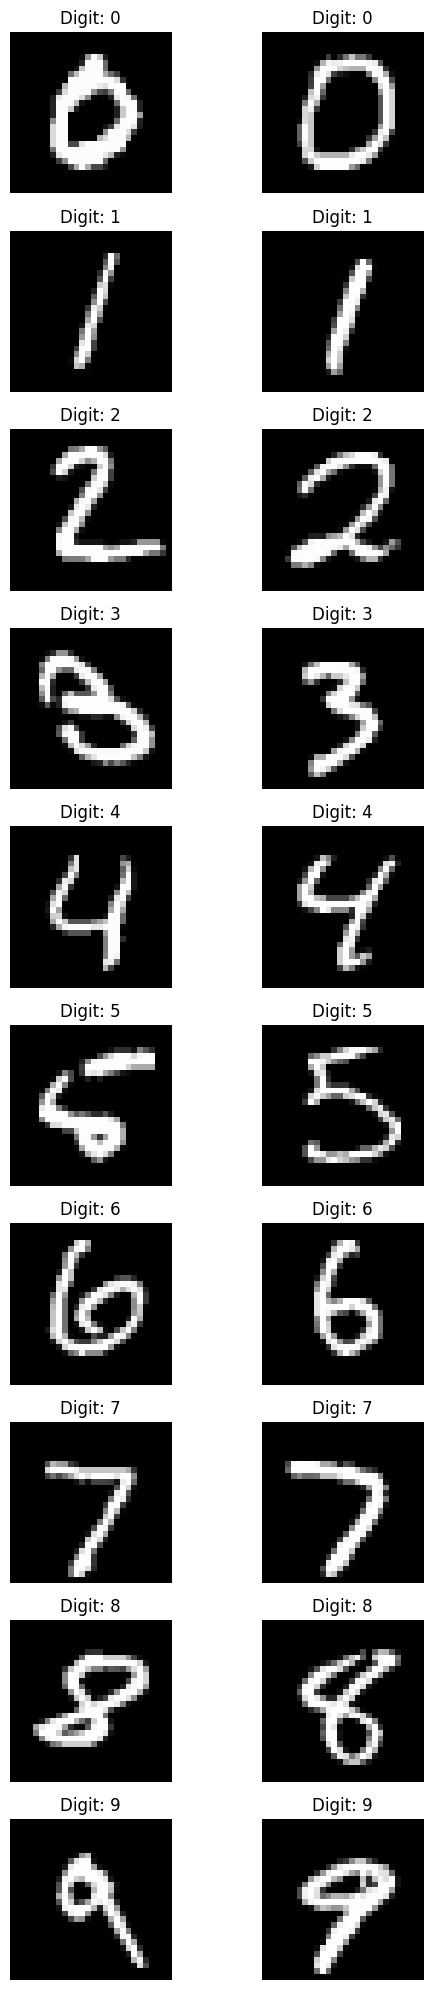

In [8]:
# Setting up a 10x2 grid of subplots
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(6, 20))

# Iterating through the digits
for digit, images in selected_images.items():
    for idx, image in enumerate(images):
        ax = axes[digit, idx]
        # Since the images are normalized, we denormalize them for visualization
        image_denormalized = image * 0.5 + 0.5
        ax.imshow(image_denormalized.squeeze().numpy(), cmap='gray')
        ax.set_title(f"Digit: {digit}")
        ax.axis('off')  # Hiding axis labels

_ = plt.tight_layout()
_ = plt.show()

In [9]:
# To store results for all images
results = []

# Iterate over digits and their corresponding images
for digit, images in selected_images.items():
    for idx, image in enumerate(images):
        # Add batch dimension and run the model
        with torch.no_grad():
            image = image.unsqueeze(0)  # Add batch dimension
            output = model(image)
            predicted_label = torch.argmax(output).item()
            probabilities = F.softmax(output, dim=1)  # Apply softmax to get the probabilities
            prediction_score = probabilities[0][predicted_label].item()  # Confidence score for the predicted label
        
        # Store the results
        result = {
            "True Label": digit,
            "Predicted Label": predicted_label,
            "Confidence Score": prediction_score,
            "Probability Distribution": probabilities[0].tolist()
        }
        results.append(result)

# Displaying the results
for res in results:
    print(f"True Label: {res['True Label']}")
    print(f"Predicted Label: {res['Predicted Label']}")
    print(f"Confidence Score for the Predicted Label: {res['Confidence Score']:.4f}")
    print(f"Probability Distribution over Classes: {res['Probability Distribution']}")
    print("="*50)


True Label: 0
Predicted Label: 0
Confidence Score for the Predicted Label: 1.0000
Probability Distribution over Classes: [1.0, 3.4913989477303176e-09, 1.8374006760524253e-09, 4.237037803944688e-12, 3.7691216814295103e-10, 1.313967129545901e-10, 1.6552148096593555e-08, 9.086875696340257e-11, 1.1621150264318203e-08, 3.100124379429303e-09]
True Label: 0
Predicted Label: 0
Confidence Score for the Predicted Label: 1.0000
Probability Distribution over Classes: [0.9999998807907104, 6.828754095522527e-08, 1.2071756927412025e-08, 5.543113277411971e-12, 3.4147562555375544e-10, 3.565198414268167e-10, 4.895054583897718e-09, 3.6958108795559497e-10, 1.090045476104251e-08, 6.982720623938121e-09]
True Label: 1
Predicted Label: 1
Confidence Score for the Predicted Label: 1.0000
Probability Distribution over Classes: [9.722501914666282e-08, 0.9999738931655884, 1.0812779009938822e-06, 1.5509867523633147e-07, 6.848660518699035e-07, 1.947417786141159e-06, 1.6554976411953248e-07, 2.005036913033109e-05, 1.5

In [10]:
integrated_gradients = IntegratedGradients(model)

# Store the attributions for each image
attributions_list = []

# Iterate over images and results
for (digit, images), res in zip(selected_images.items(), results):
    for idx, image in enumerate(images):
        predicted_label = res["Predicted Label"]  # Retrieve the predicted label from results
        transformed_img = image.unsqueeze(0)  # Add batch dimension and send to device

        # Compute the attributions using Integrated Gradients
        attributions_ig = integrated_gradients.attribute(transformed_img, target=predicted_label, n_steps=200)
        attributions_list.append(attributions_ig)

In [11]:
attributions_list

[tensor([[[[-5.0016e-03, -2.3972e-02, -4.8634e-03, -1.1353e-02, -8.2141e-03,
             1.6495e-02,  6.2163e-03,  2.5611e-02, -8.1013e-03,  1.0555e-02,
            -1.3585e-02,  1.5146e-02,  1.3393e-02, -4.3330e-03,  3.1803e-04,
            -1.1890e-02, -7.4264e-03, -3.3696e-02, -1.8310e-02, -2.0301e-02,
            -9.1732e-03,  1.2249e-02, -5.3298e-03, -1.9074e-03, -6.0394e-03,
            -3.3517e-03, -1.0592e-02, -1.7326e-02],
           [-2.3612e-02, -6.7533e-02, -8.4733e-02, -2.5550e-02, -4.4884e-02,
            -1.7228e-02, -3.8699e-02,  3.0702e-02, -3.9512e-03,  1.0048e-02,
            -3.7998e-02, -2.0351e-02, -3.2922e-02, -2.4119e-02, -4.6659e-02,
            -3.3439e-02, -6.1117e-02, -3.1072e-02, -4.3976e-02, -9.2220e-02,
            -5.6084e-02,  1.7269e-03, -1.5885e-02,  5.5014e-03,  1.3128e-02,
             1.2248e-02, -6.1611e-03, -1.3861e-02],
           [ 4.8071e-03, -1.8851e-02, -1.7318e-02,  3.5081e-03, -2.4524e-02,
            -1.9804e-03, -2.3697e-03,  1.3338e-02

In [12]:
print(attributions_list[0].squeeze().cpu().detach().numpy().shape)
transformed_img.squeeze().cpu().detach().numpy().shape

(28, 28)


(28, 28)

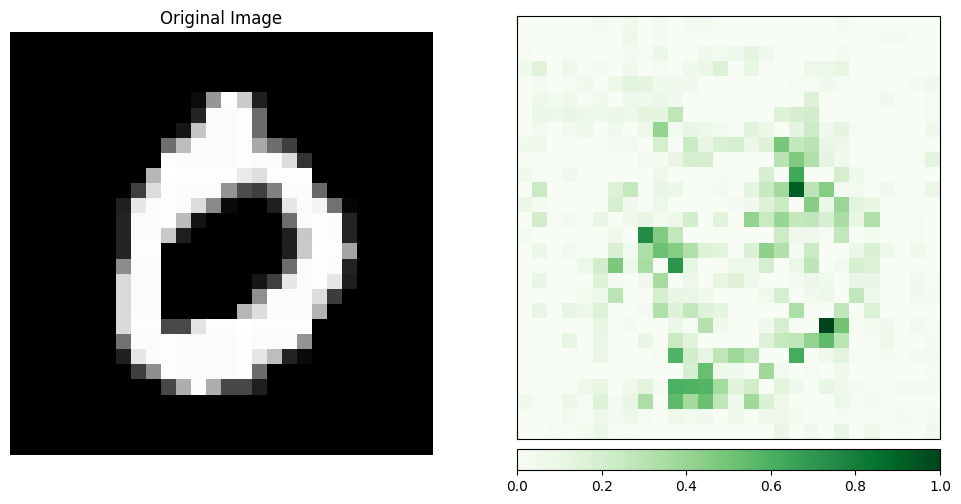

<Figure size 640x480 with 0 Axes>

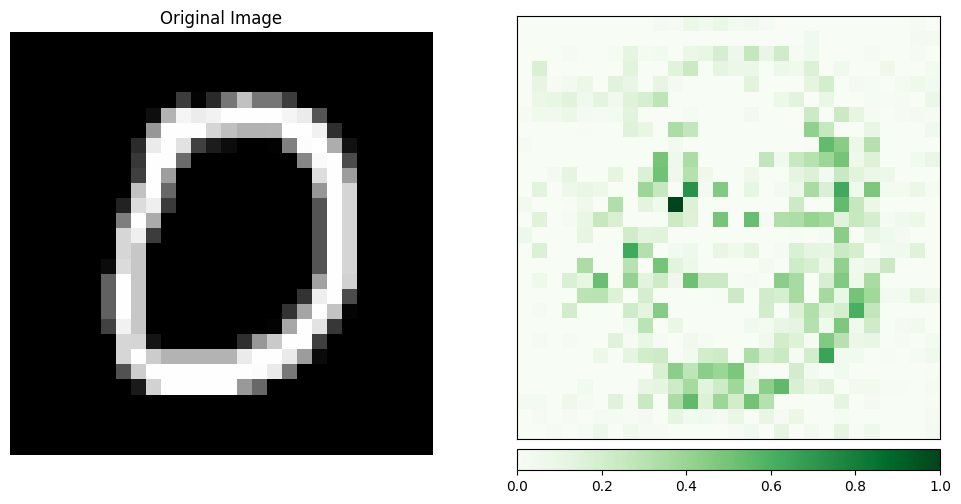

<Figure size 640x480 with 0 Axes>

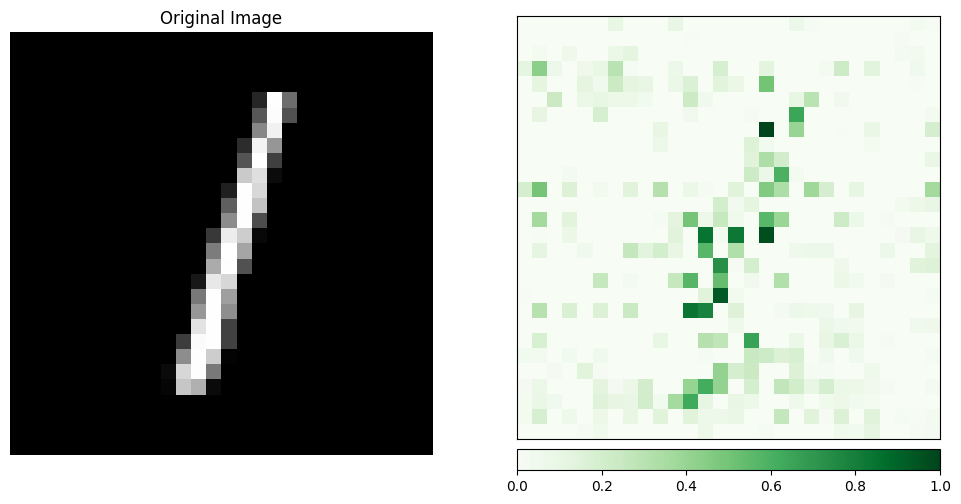

<Figure size 640x480 with 0 Axes>

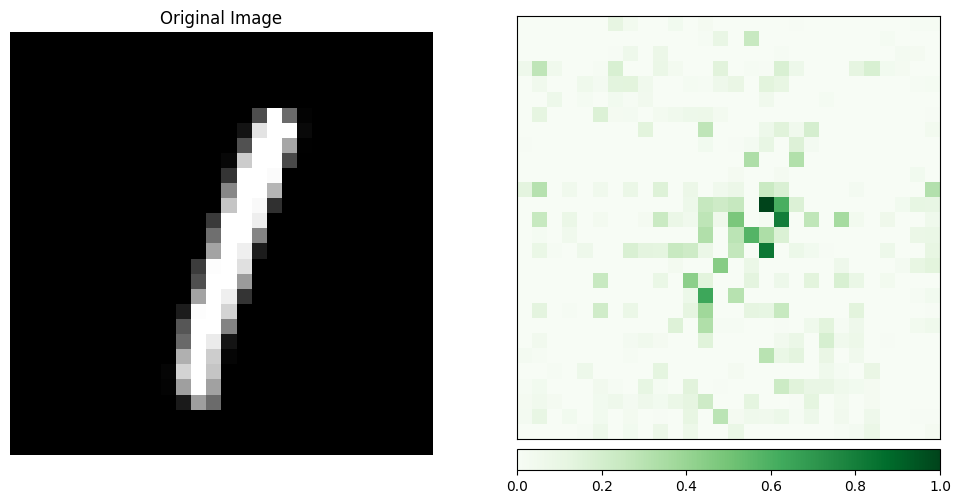

<Figure size 640x480 with 0 Axes>

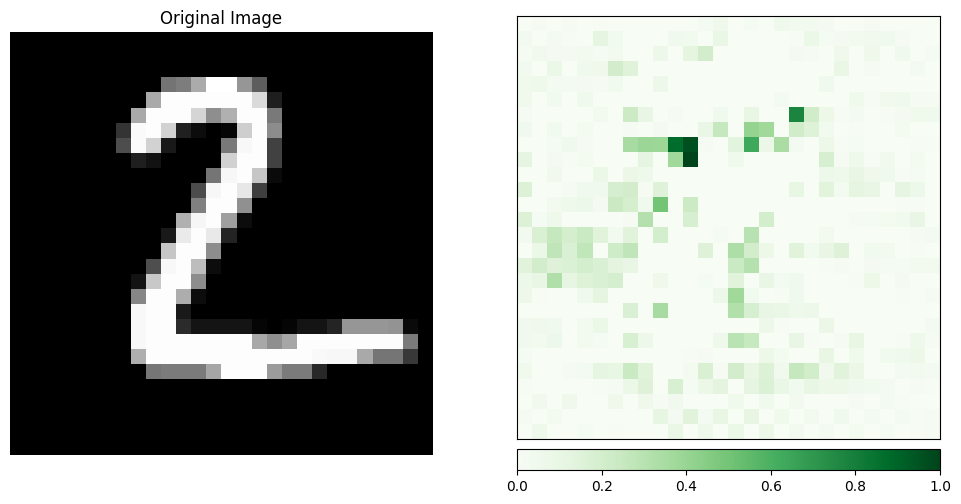

<Figure size 640x480 with 0 Axes>

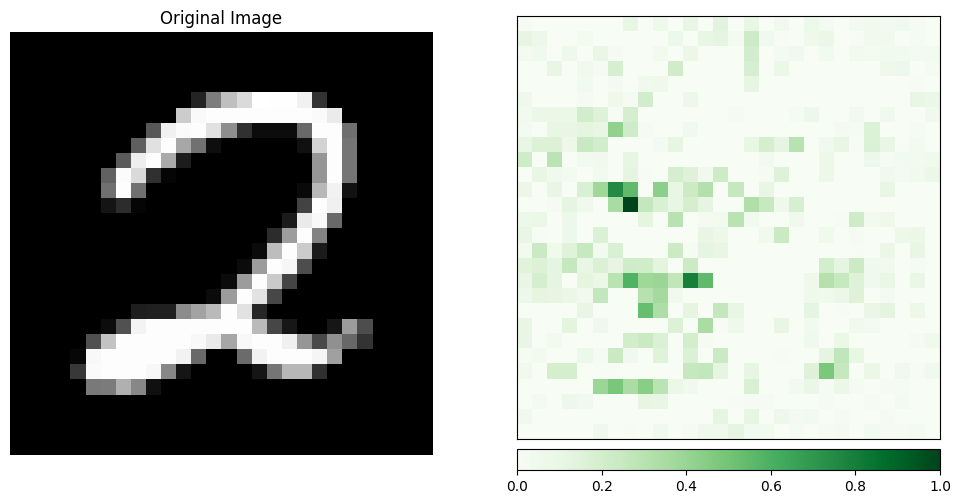

<Figure size 640x480 with 0 Axes>

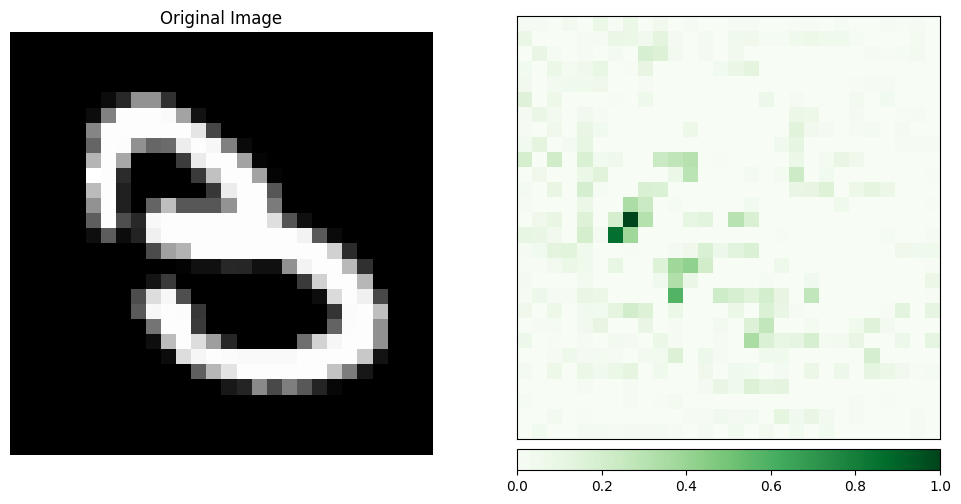

<Figure size 640x480 with 0 Axes>

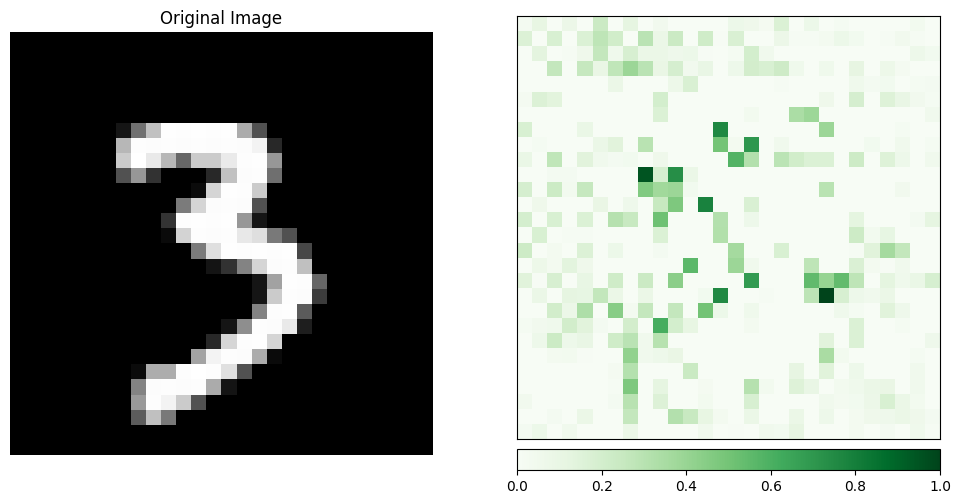

<Figure size 640x480 with 0 Axes>

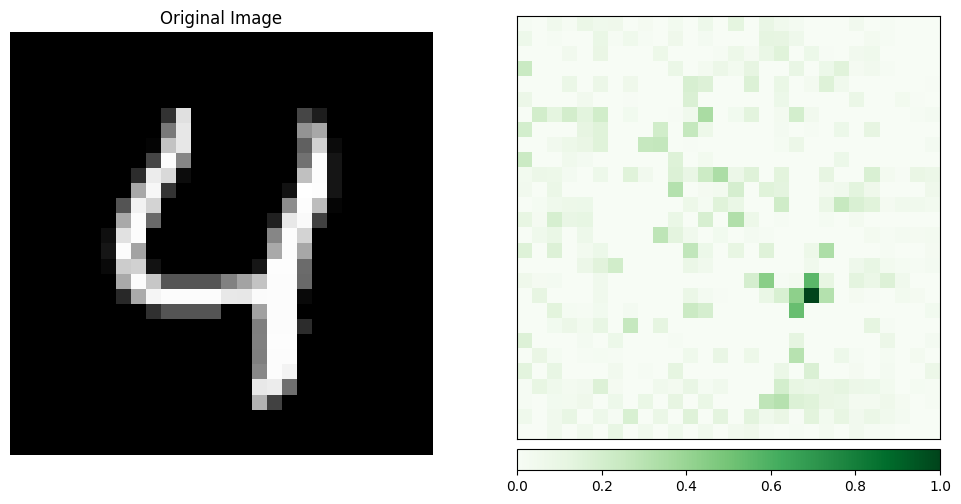

<Figure size 640x480 with 0 Axes>

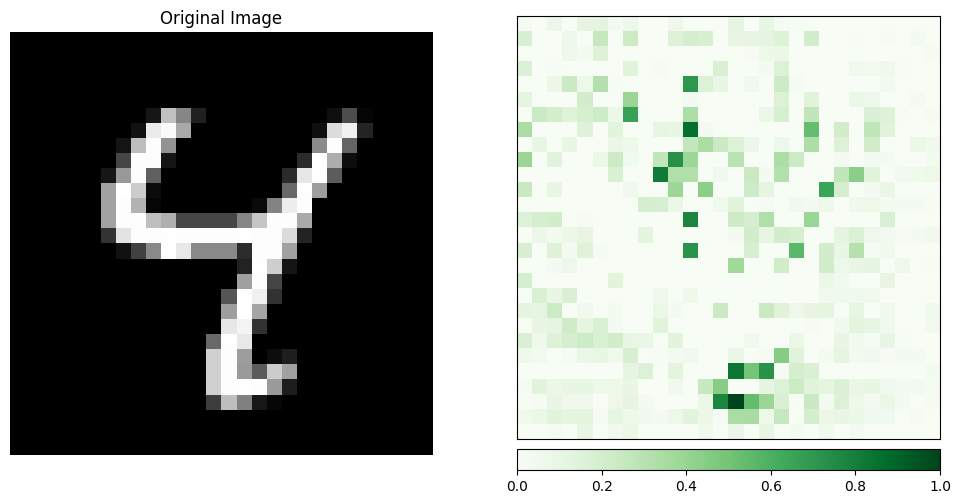

<Figure size 640x480 with 0 Axes>

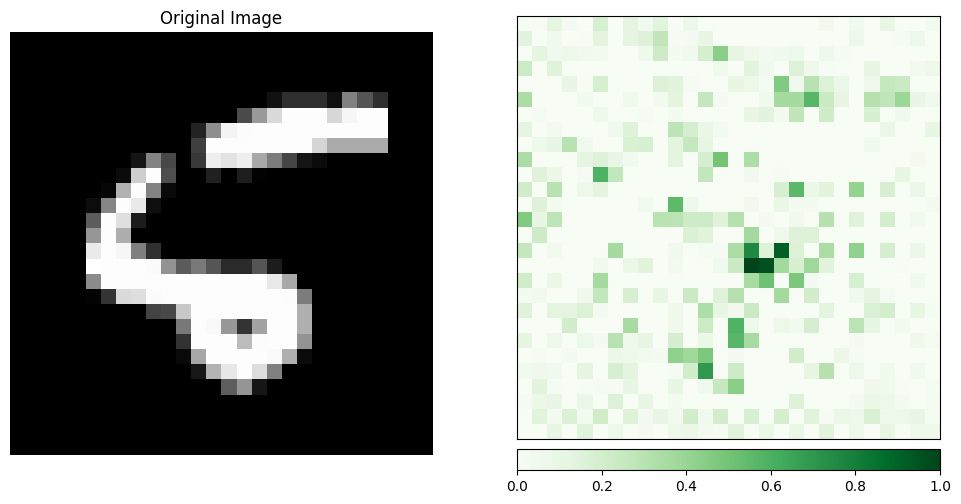

<Figure size 640x480 with 0 Axes>

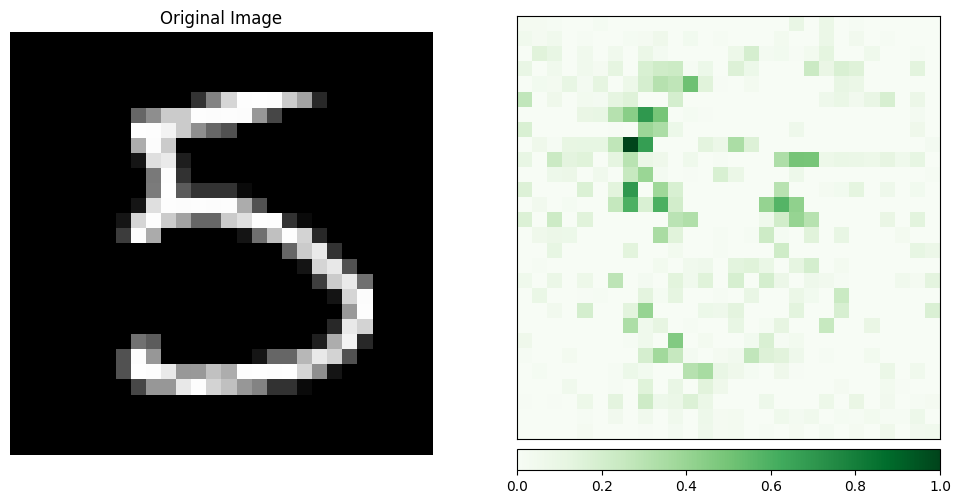

<Figure size 640x480 with 0 Axes>

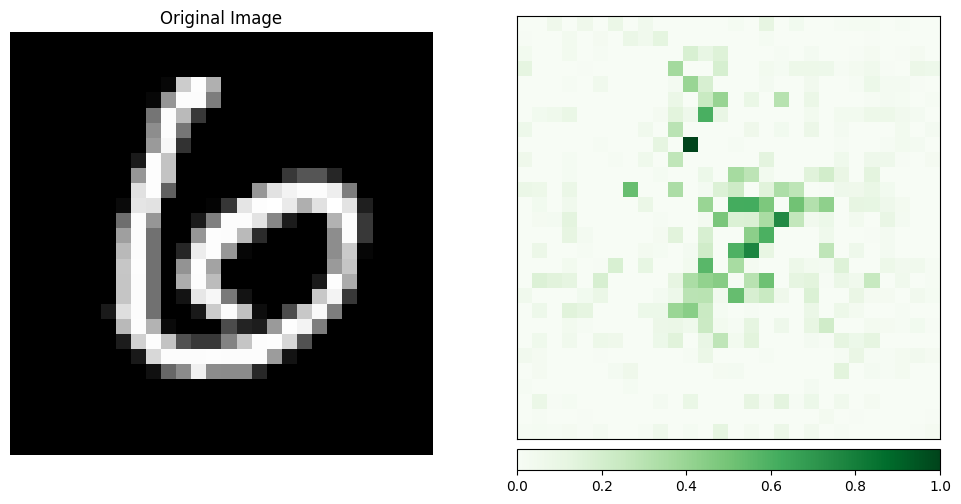

<Figure size 640x480 with 0 Axes>

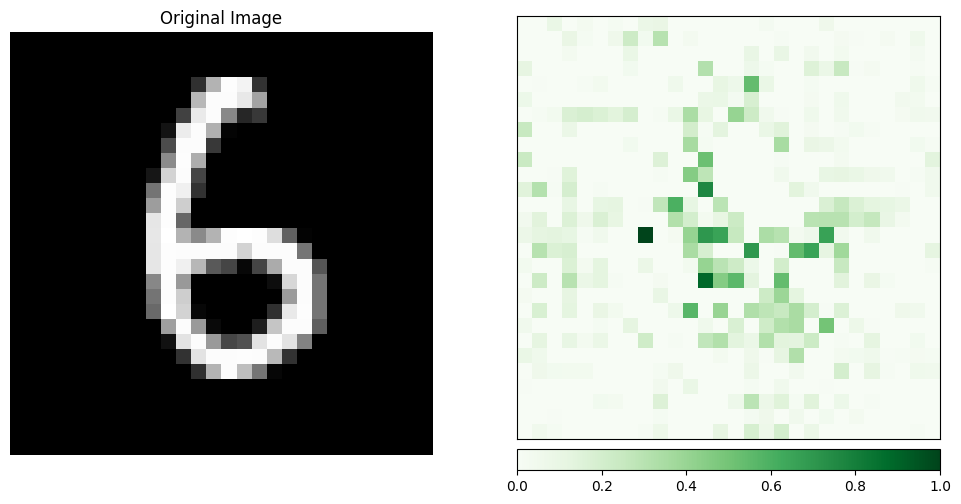

<Figure size 640x480 with 0 Axes>

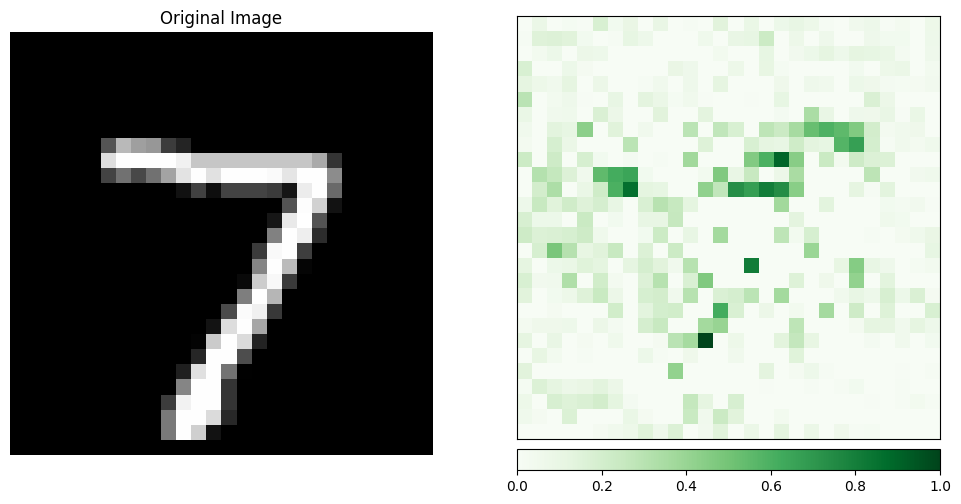

<Figure size 640x480 with 0 Axes>

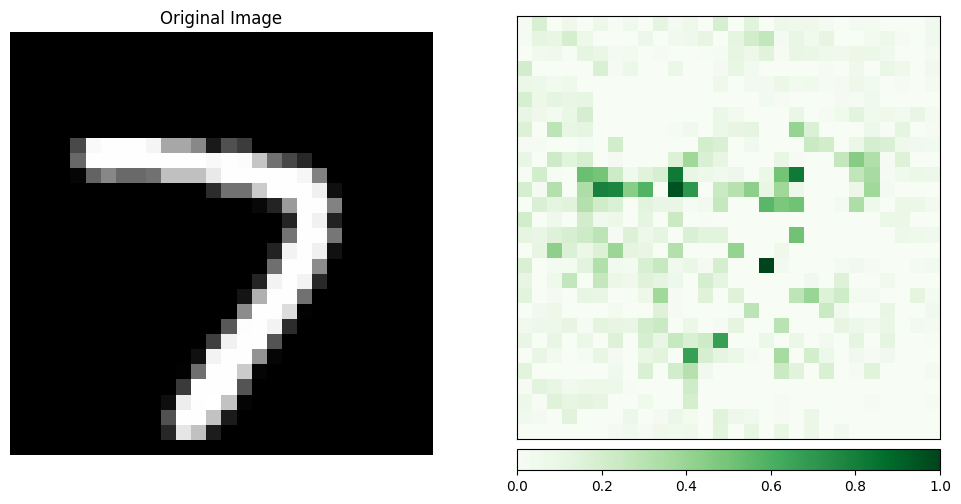

<Figure size 640x480 with 0 Axes>

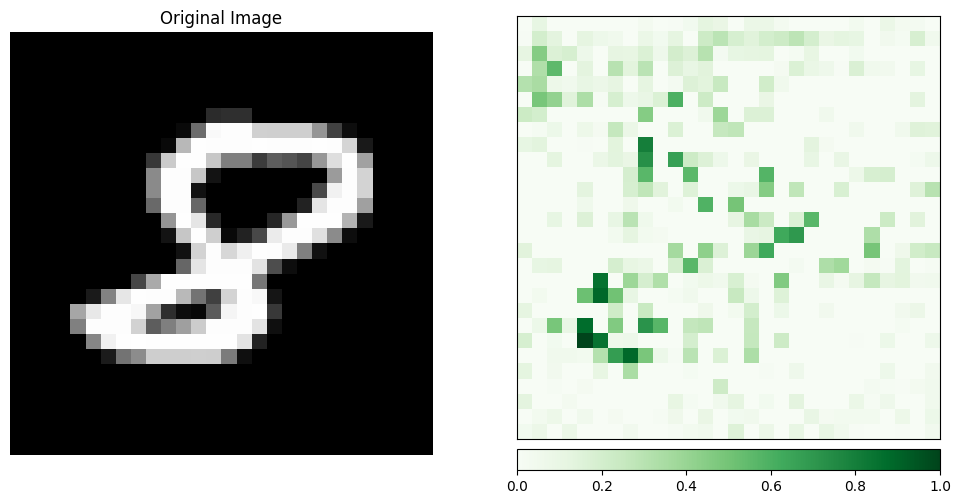

<Figure size 640x480 with 0 Axes>

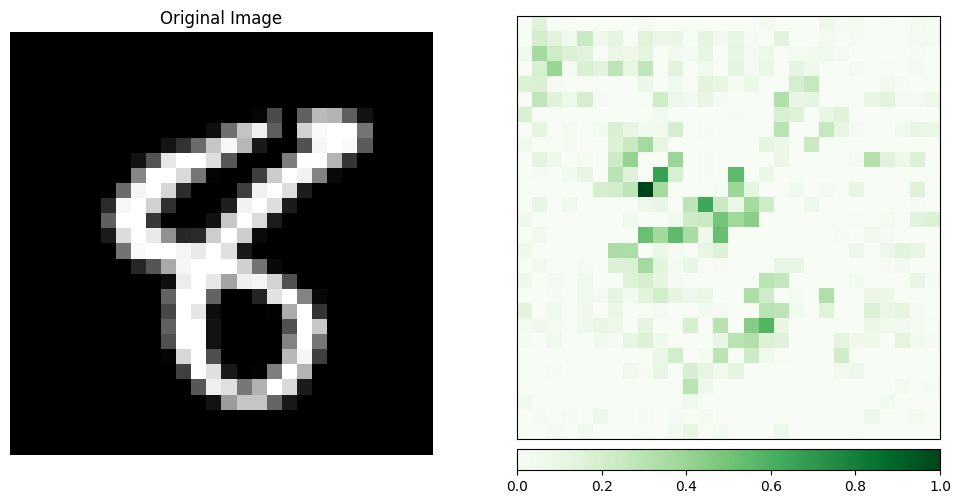

<Figure size 640x480 with 0 Axes>

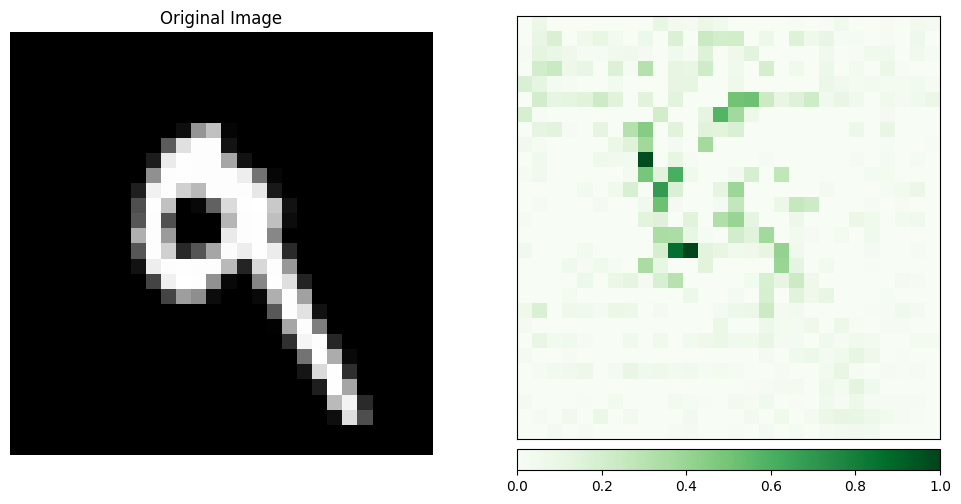

<Figure size 640x480 with 0 Axes>

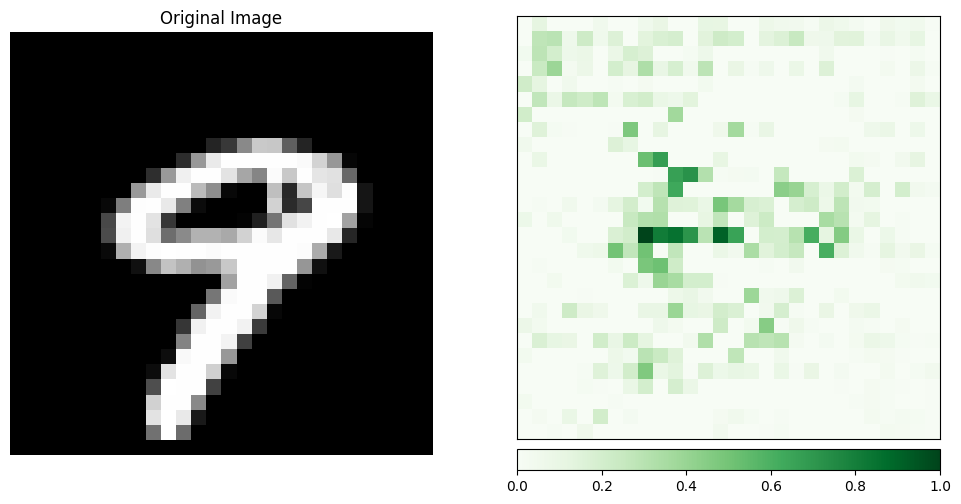

<Figure size 640x480 with 0 Axes>

In [13]:
# Create a flat list of images to match the order of attributions
selected_images_list = [img for _, imgs in selected_images.items() for img in imgs]

# Iterate over the attributions and corresponding images
for idx, (attributions, image) in enumerate(zip(attributions_list, selected_images_list)):
    attr_reshaped = attributions.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)

    # Create a single plot with two subplots: one for the original image and one for the attribution
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    # Display the original image on the first subplot
    axes[0].imshow(img_reshaped, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display the attribution on the second subplot
    _ = viz.visualize_image_attr(attr_reshaped,
                                 img_reshaped,
                                 method='heat_map',
                                 show_colorbar=True,
                                 sign='positive',
                                 outlier_perc=1,
                                 plt_fig_axis=(fig, axes[1]))
    axes[1].set_title("Attribution Map")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


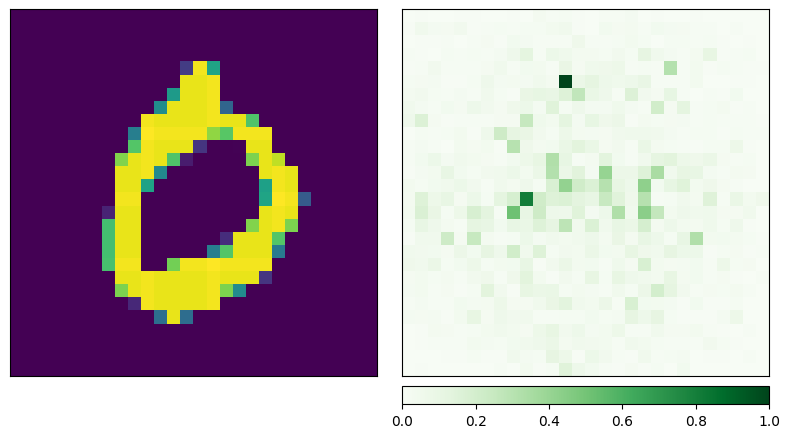

<Figure size 640x480 with 0 Axes>

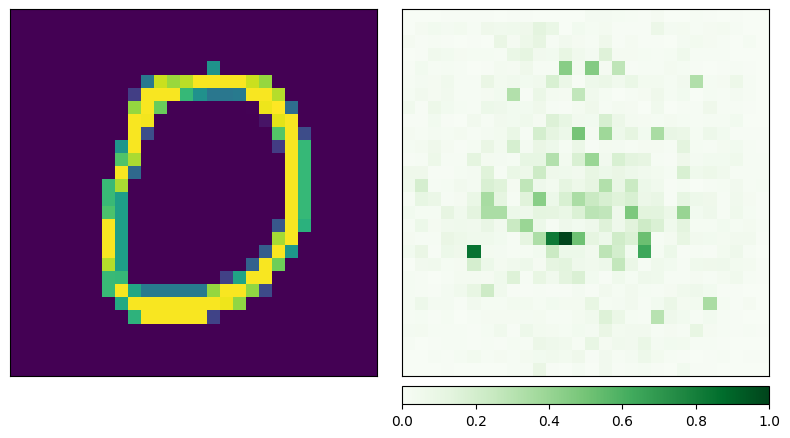

<Figure size 640x480 with 0 Axes>

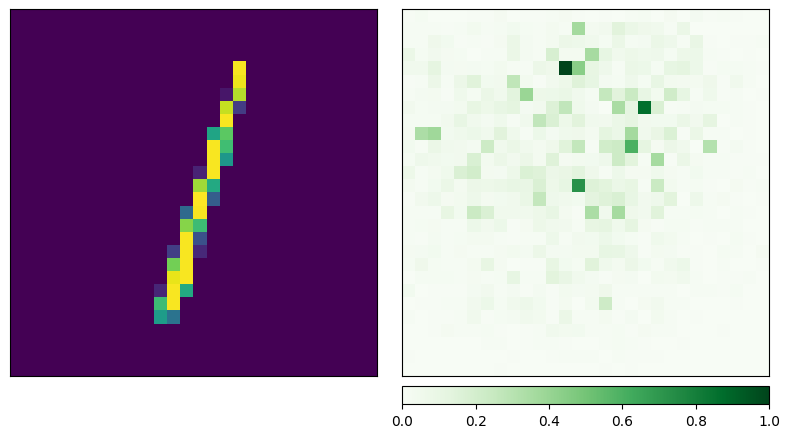

<Figure size 640x480 with 0 Axes>

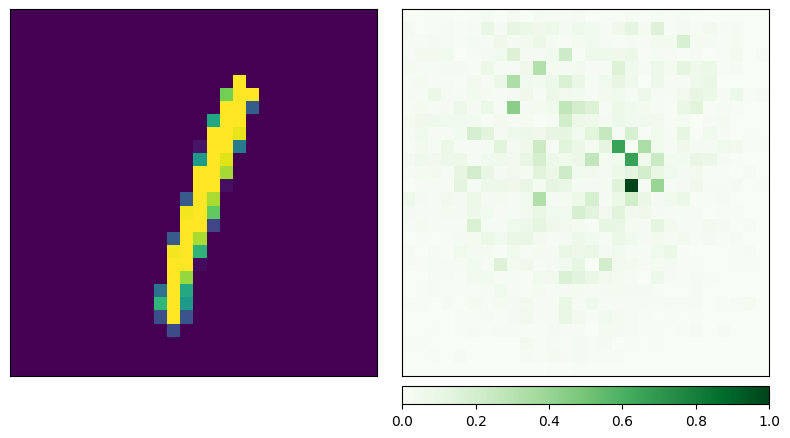

<Figure size 640x480 with 0 Axes>

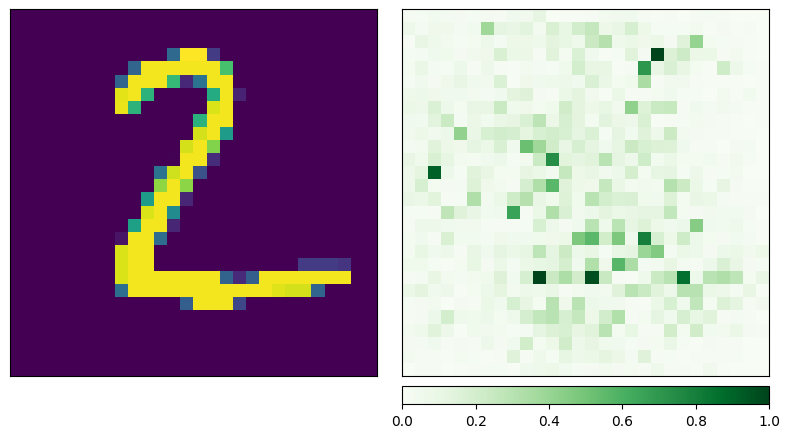

<Figure size 640x480 with 0 Axes>

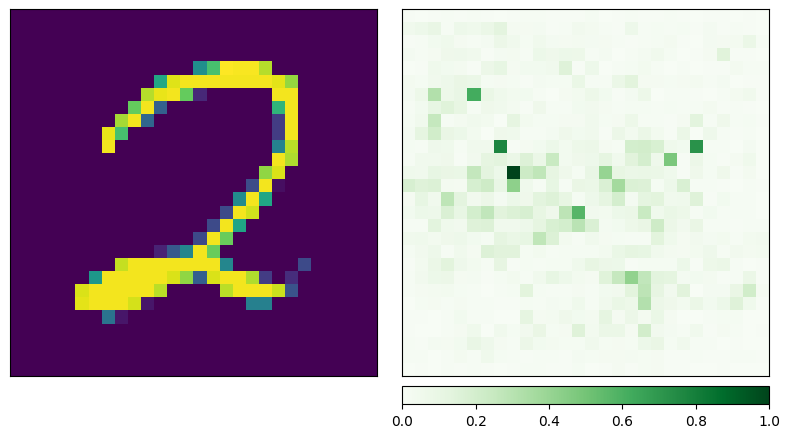

<Figure size 640x480 with 0 Axes>

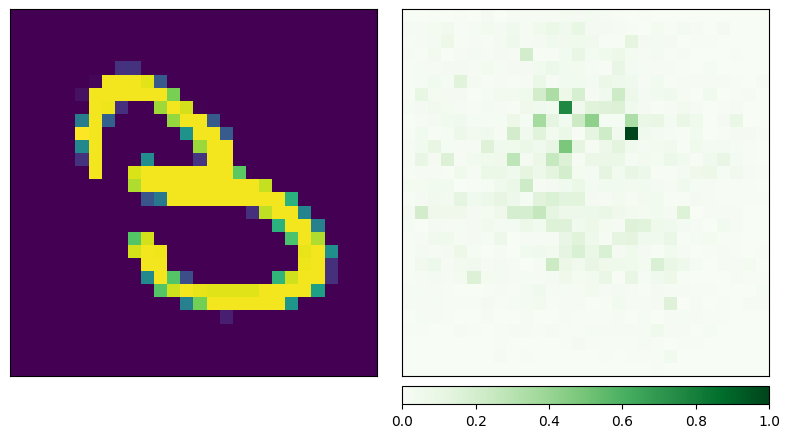

<Figure size 640x480 with 0 Axes>

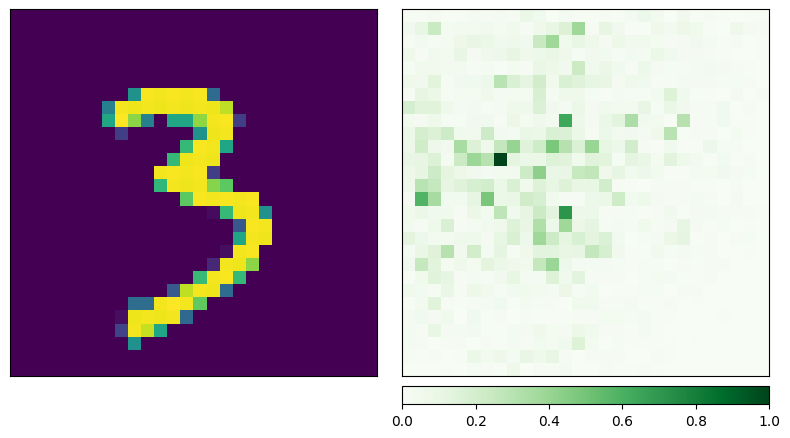

<Figure size 640x480 with 0 Axes>

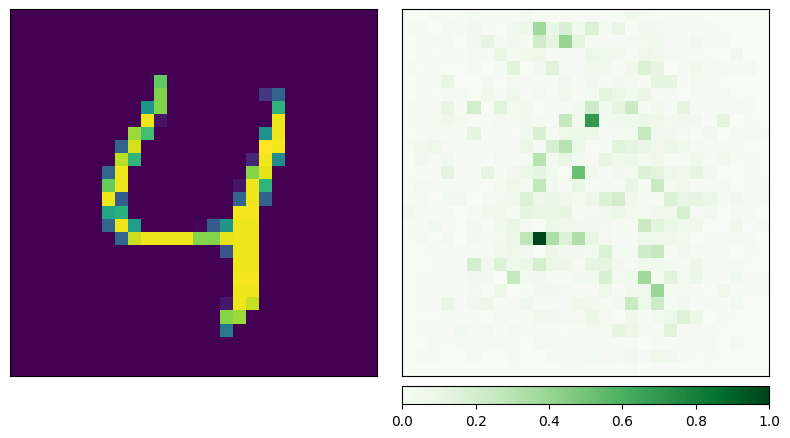

<Figure size 640x480 with 0 Axes>

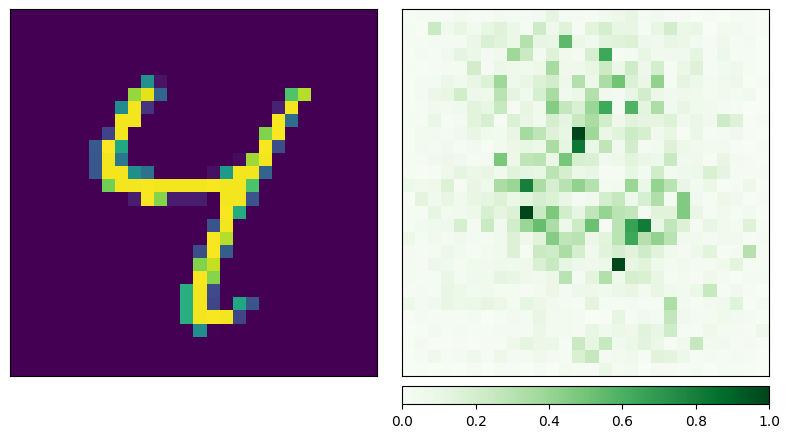

<Figure size 640x480 with 0 Axes>

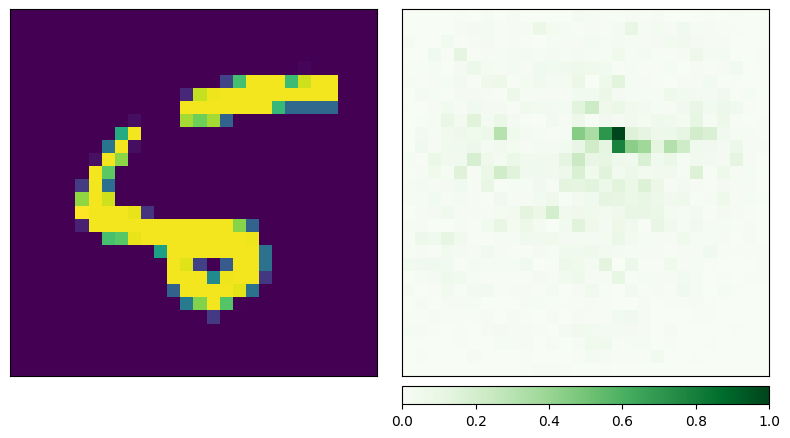

<Figure size 640x480 with 0 Axes>

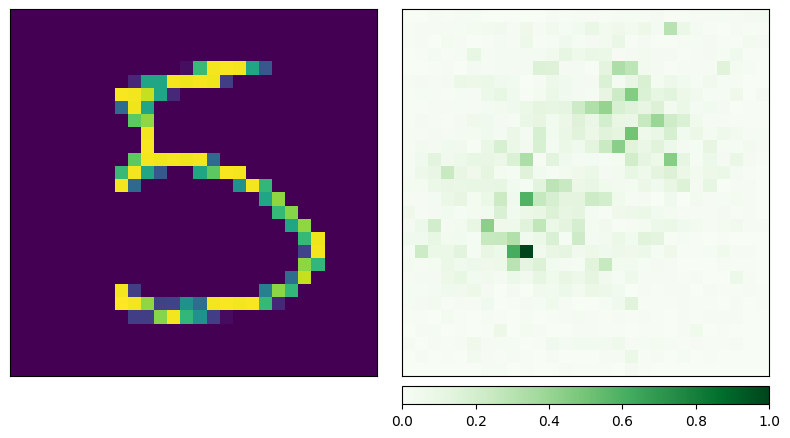

<Figure size 640x480 with 0 Axes>

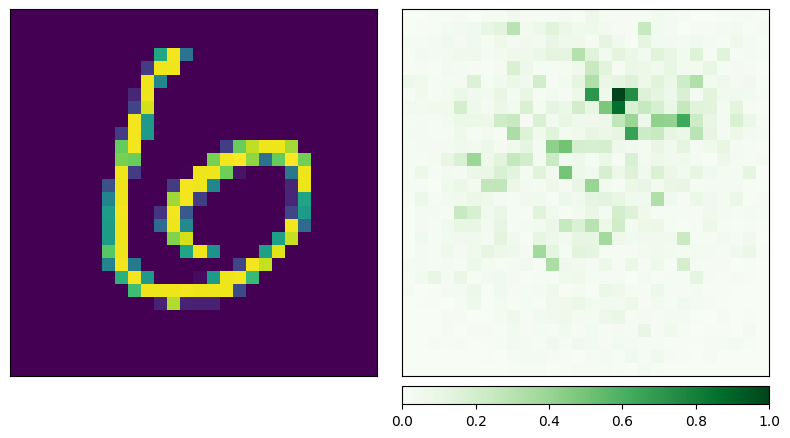

<Figure size 640x480 with 0 Axes>

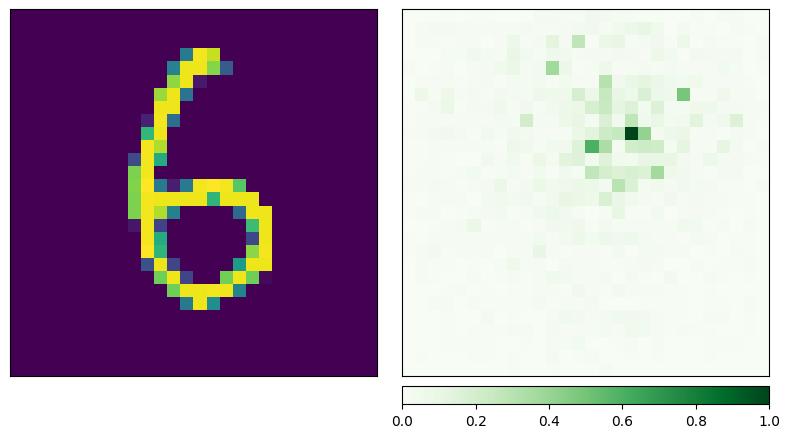

<Figure size 640x480 with 0 Axes>

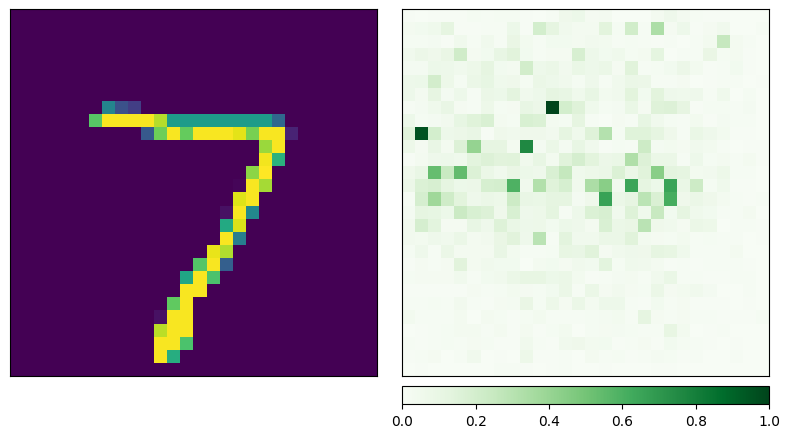

<Figure size 640x480 with 0 Axes>

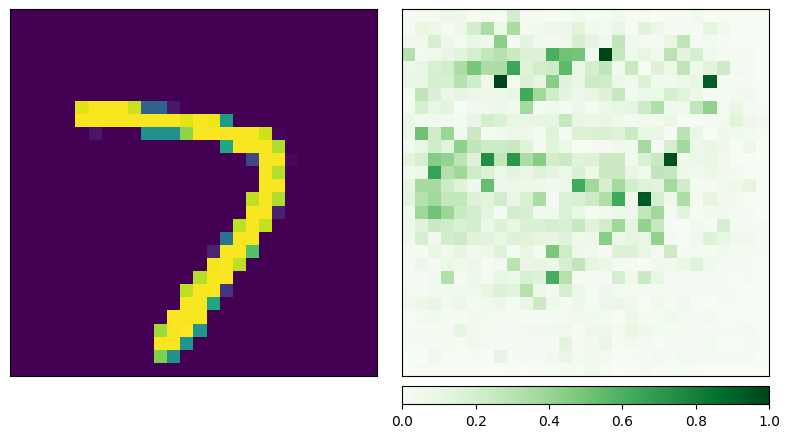

<Figure size 640x480 with 0 Axes>

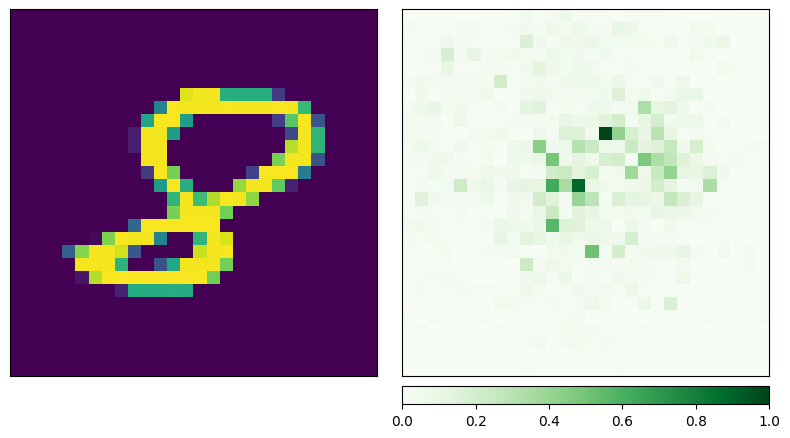

<Figure size 640x480 with 0 Axes>

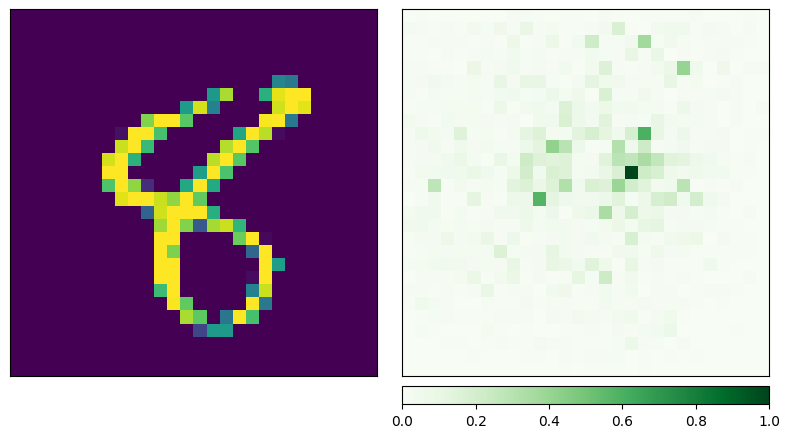

<Figure size 640x480 with 0 Axes>

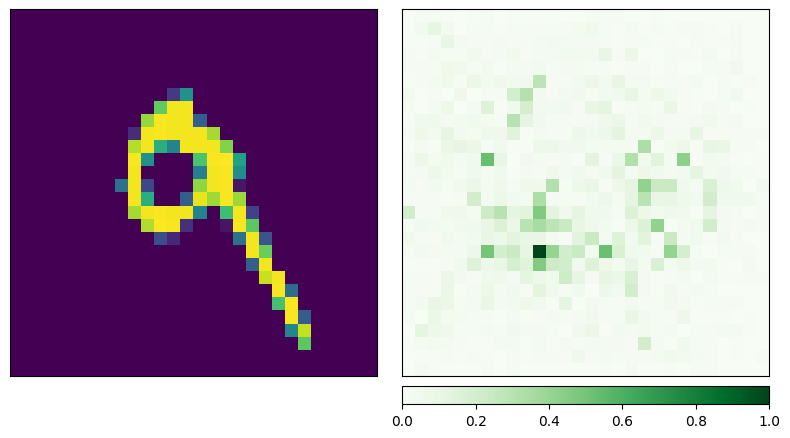

<Figure size 640x480 with 0 Axes>

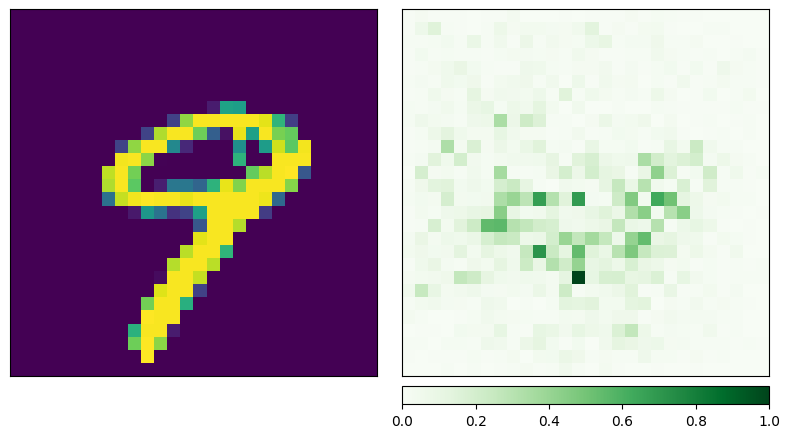

<Figure size 640x480 with 0 Axes>

In [14]:
noise_tunnel = NoiseTunnel(integrated_gradients)
predicted_labels = [res["Predicted Label"] for res in results]
# Loop through each selected image
for image, predicted_label in zip(selected_images_list, predicted_labels):

    # Generate attributions using NoiseTunnel with IntegratedGradients
    input_img = image.unsqueeze(0)  # Add batch dimension
    attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=10, nt_type='smoothgrad_sq', target=predicted_label)

    # Prepare the reshaped attribution and image for visualization
    attr_reshaped = attributions_ig_nt.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    
    # Visualize the original image and the attribution side by side
    _ = viz.visualize_image_attr_multiple(attr_reshaped,
                                          img_reshaped,
                                          ["original_image", "heat_map"],
                                          ["all", "positive"],
                                          show_colorbar=True)
    _ = plt.tight_layout()
    _ = plt.show()

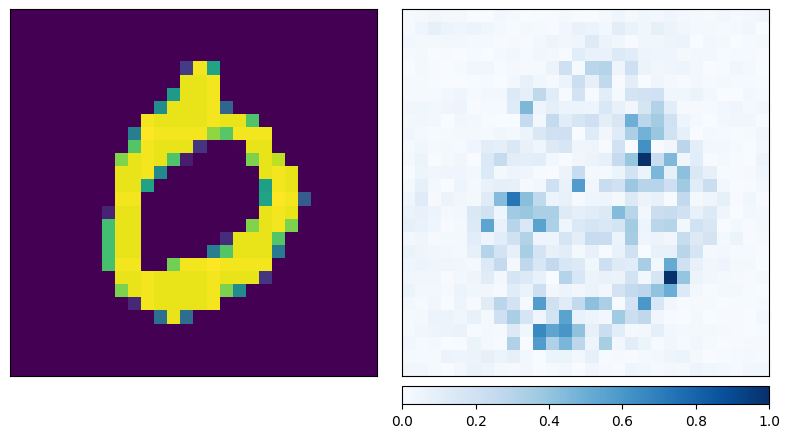

<Figure size 640x480 with 0 Axes>

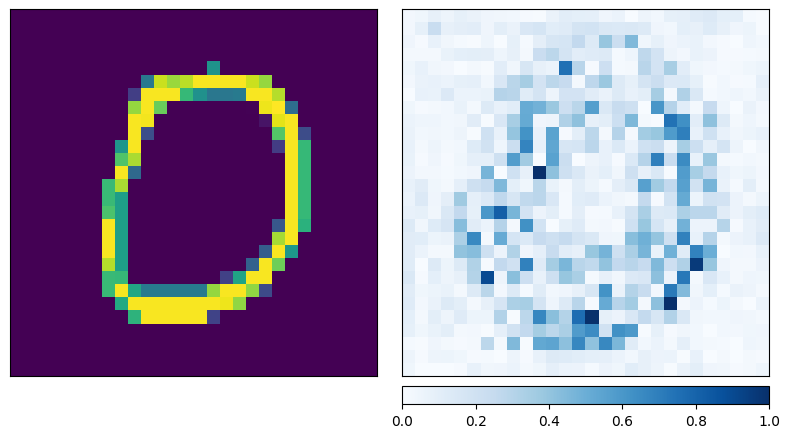

<Figure size 640x480 with 0 Axes>

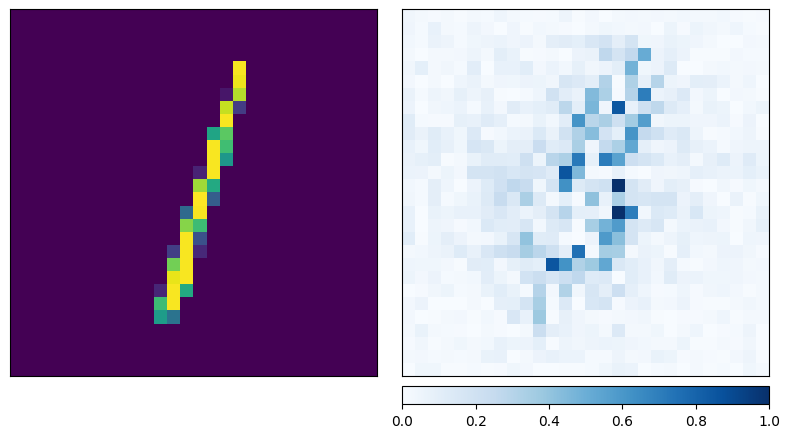

<Figure size 640x480 with 0 Axes>

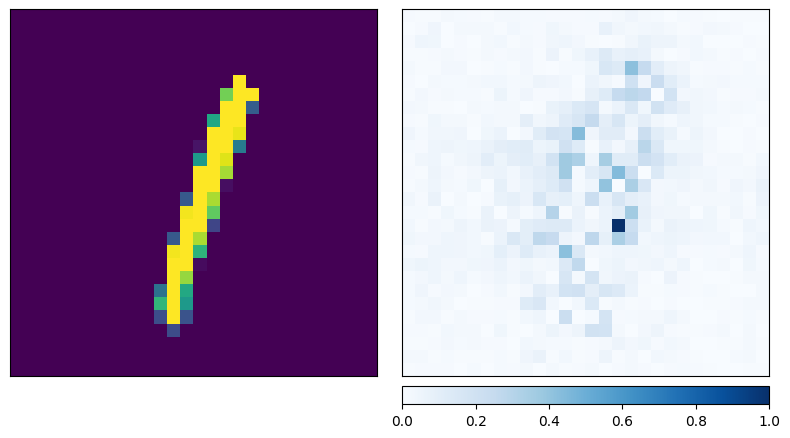

<Figure size 640x480 with 0 Axes>

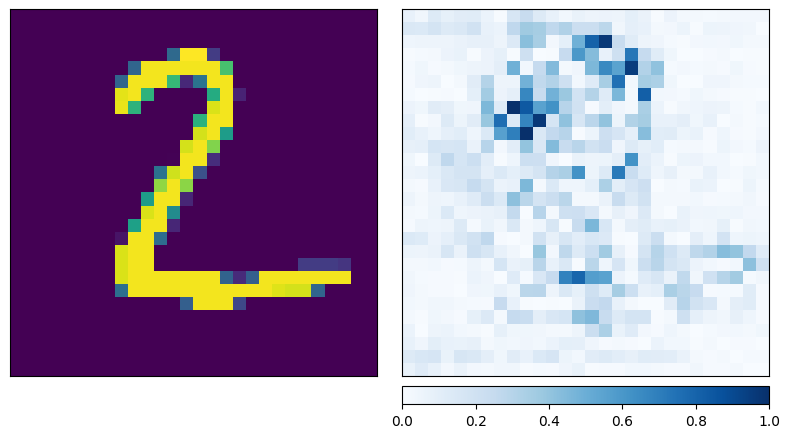

<Figure size 640x480 with 0 Axes>

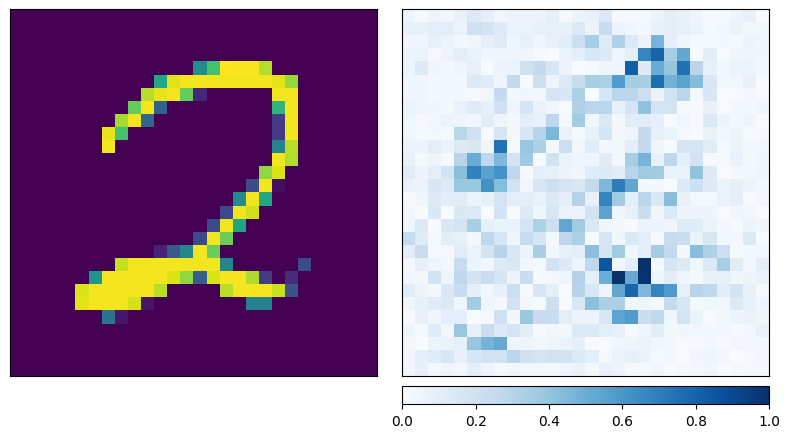

<Figure size 640x480 with 0 Axes>

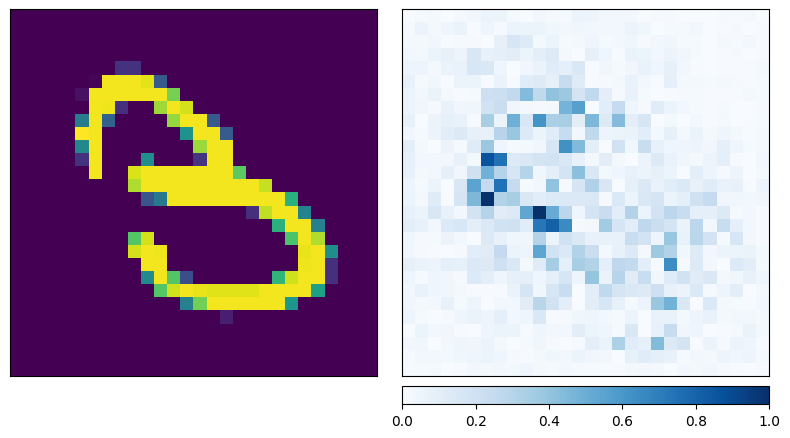

<Figure size 640x480 with 0 Axes>

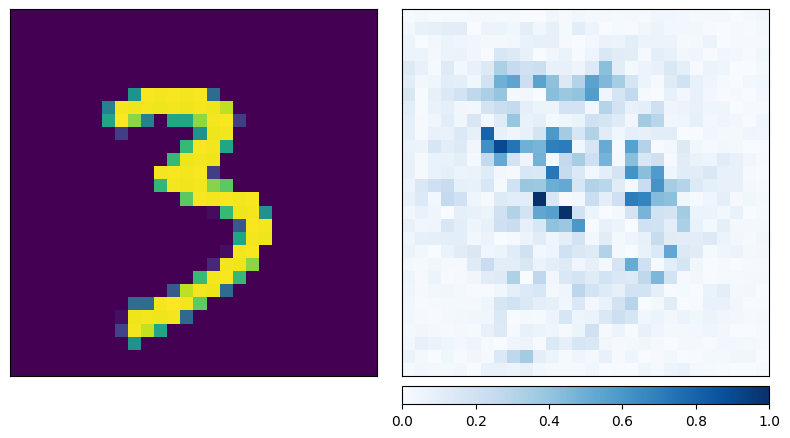

<Figure size 640x480 with 0 Axes>

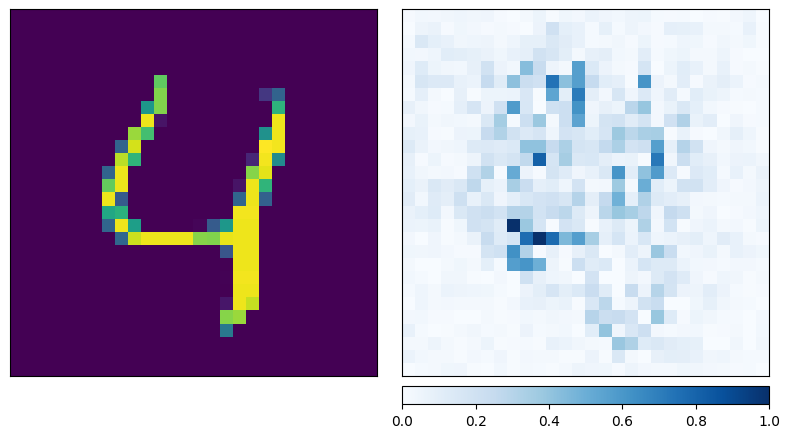

<Figure size 640x480 with 0 Axes>

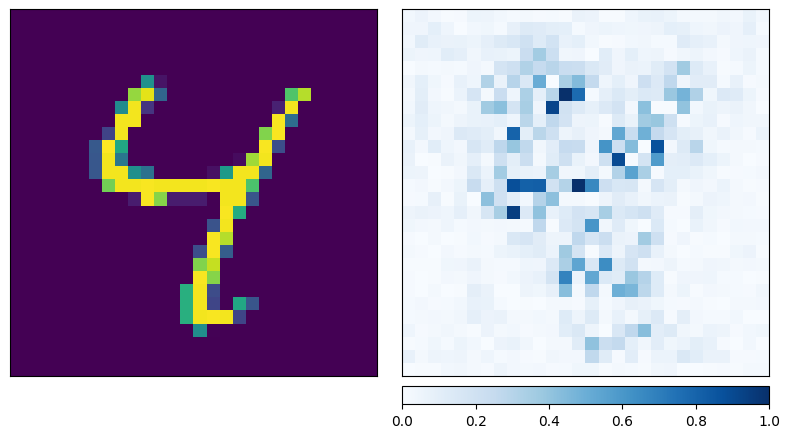

<Figure size 640x480 with 0 Axes>

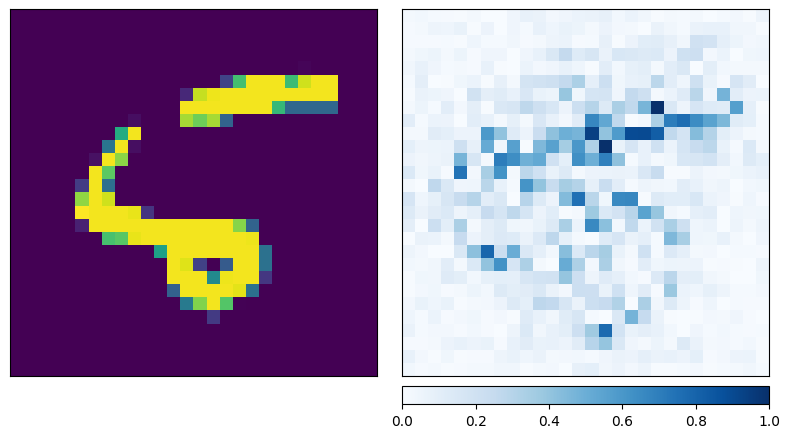

<Figure size 640x480 with 0 Axes>

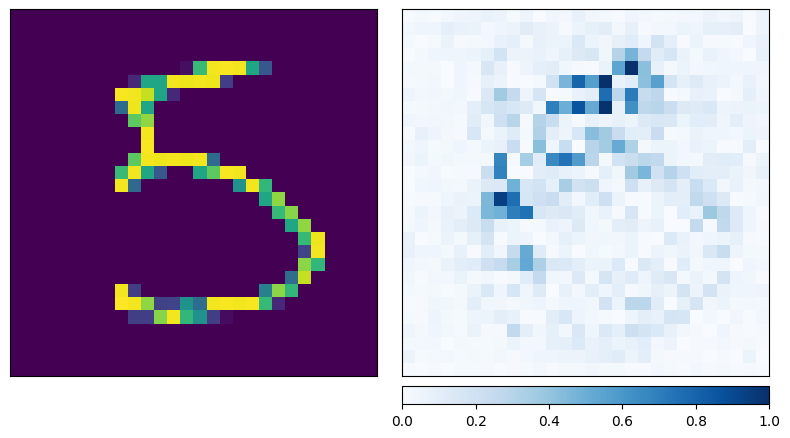

<Figure size 640x480 with 0 Axes>

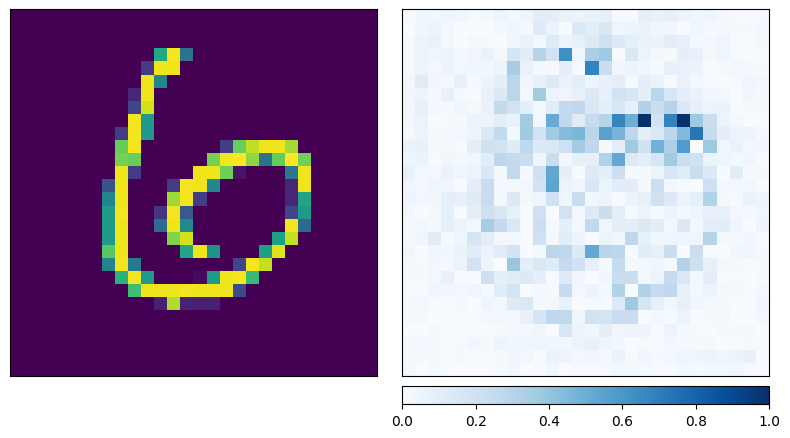

<Figure size 640x480 with 0 Axes>

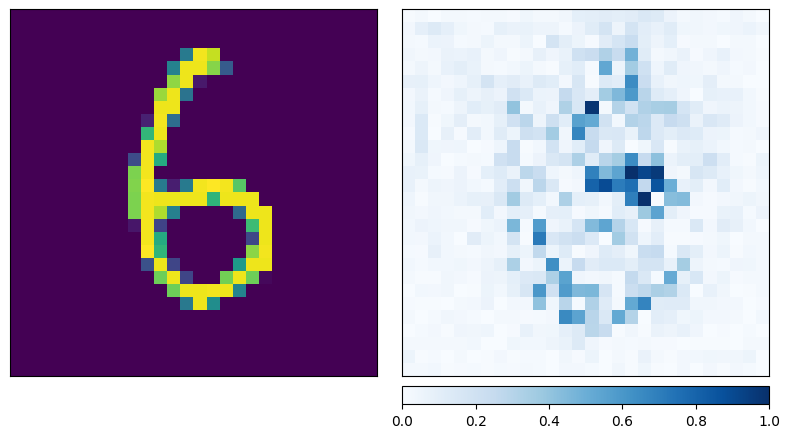

<Figure size 640x480 with 0 Axes>

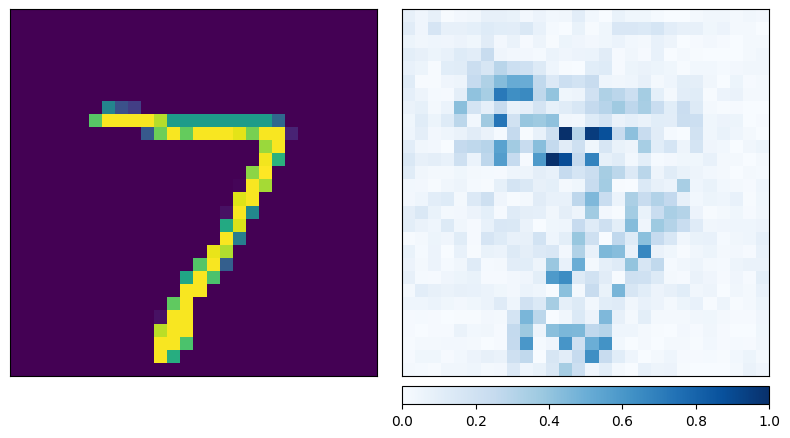

<Figure size 640x480 with 0 Axes>

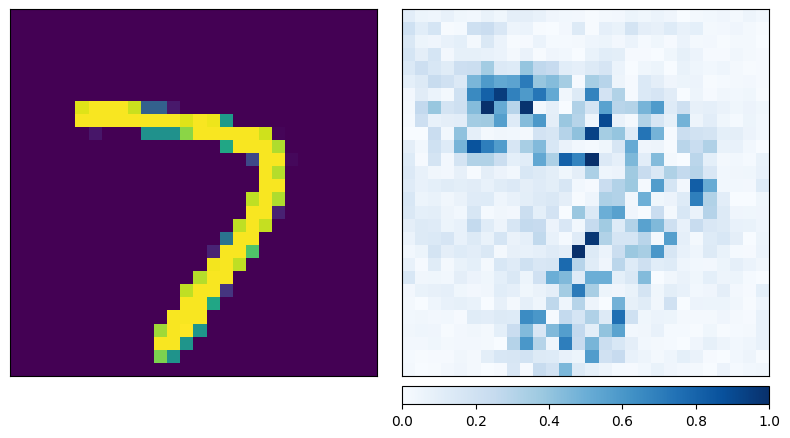

<Figure size 640x480 with 0 Axes>

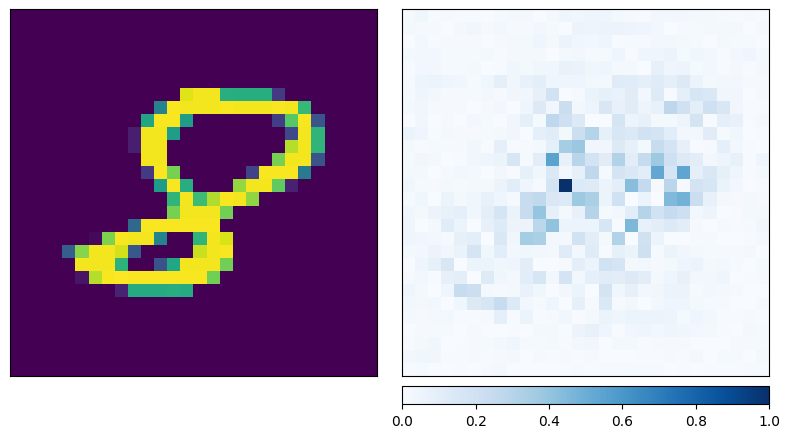

<Figure size 640x480 with 0 Axes>

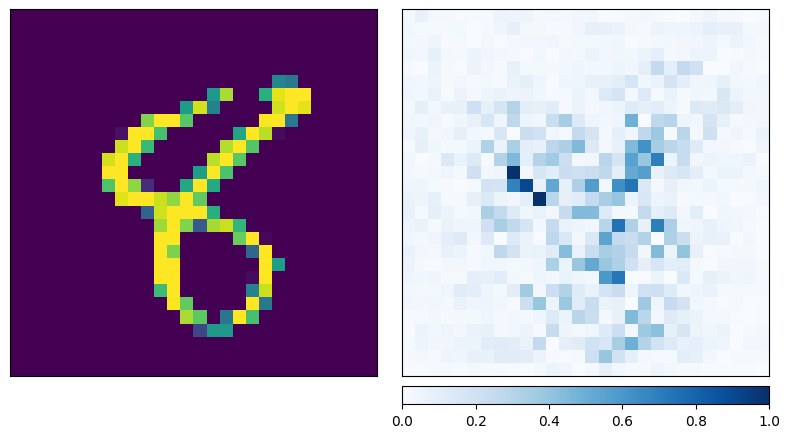

<Figure size 640x480 with 0 Axes>

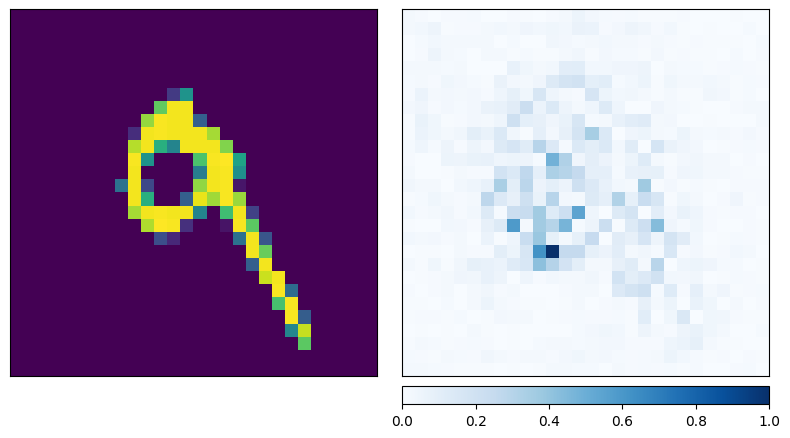

<Figure size 640x480 with 0 Axes>

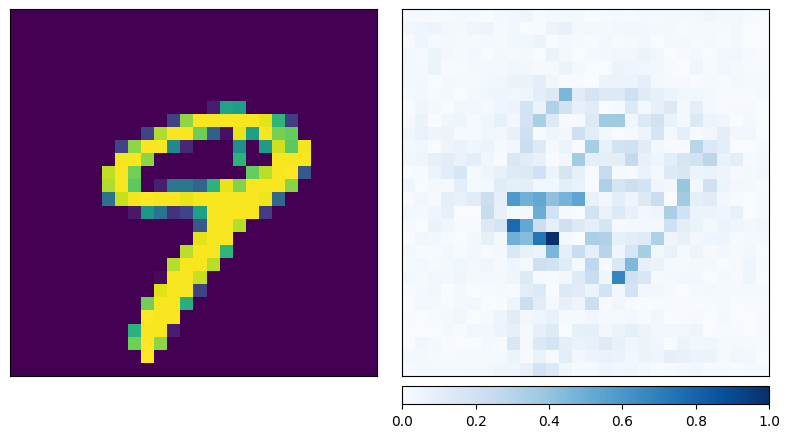

<Figure size 640x480 with 0 Axes>

In [16]:
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Loop through each selected image
for image, predicted_label in zip(selected_images_list, predicted_labels):
    
    # Prepare the image for model
    input_img = image.unsqueeze(0)  # Add batch dimension
    
    # Defining baseline distribution of images for GradientShap
    rand_img_dist = torch.cat([input_img * 0, input_img * 1])
    
    # Generate attributions using GradientShap
    attributions_gs = gradient_shap.attribute(input_img,
                                              n_samples=50,
                                              stdevs=0.0001,
                                              baselines=rand_img_dist,
                                              target=predicted_label)
    
    # Prepare the reshaped attribution and image for visualization
    attr_reshaped = attributions_gs.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    
    # Visualize the original image and the attribution side by side
    _ = viz.visualize_image_attr_multiple(attr_reshaped,
                                          img_reshaped,
                                          ["original_image", "heat_map"],
                                          ["all", "absolute_value"],
                                          show_colorbar=True)
    _ = plt.tight_layout()
    _ = plt.show()

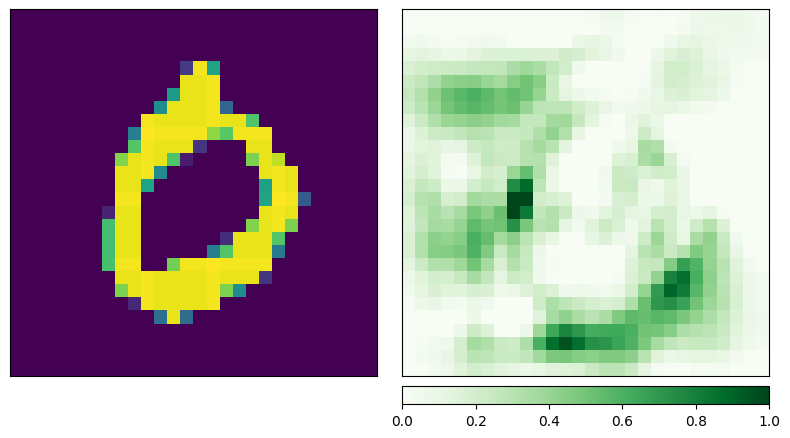

<Figure size 640x480 with 0 Axes>

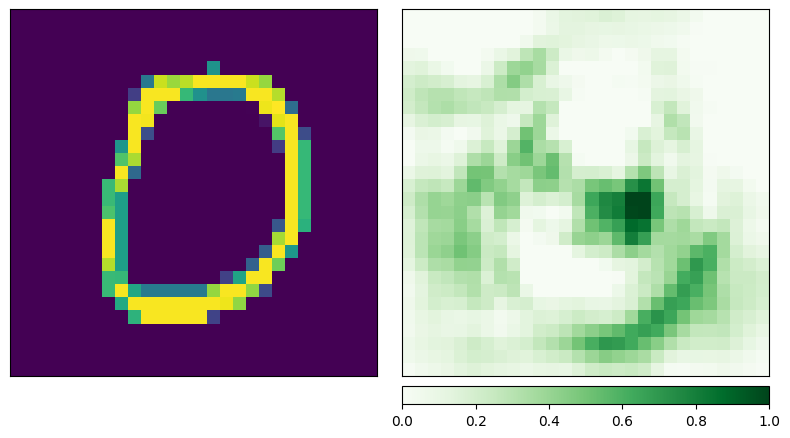

<Figure size 640x480 with 0 Axes>

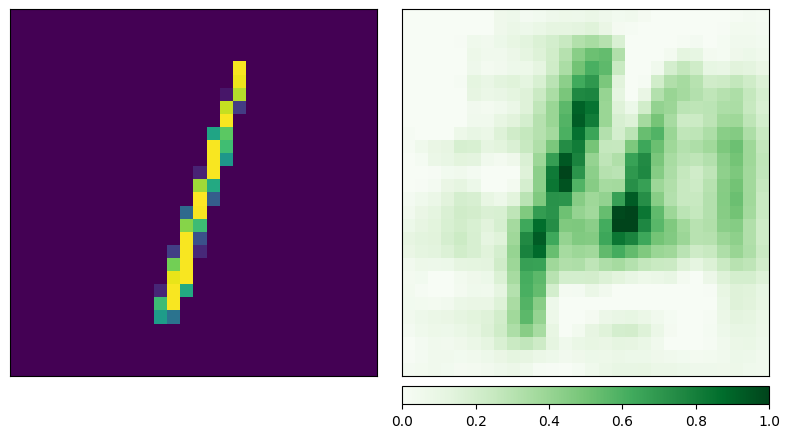

<Figure size 640x480 with 0 Axes>

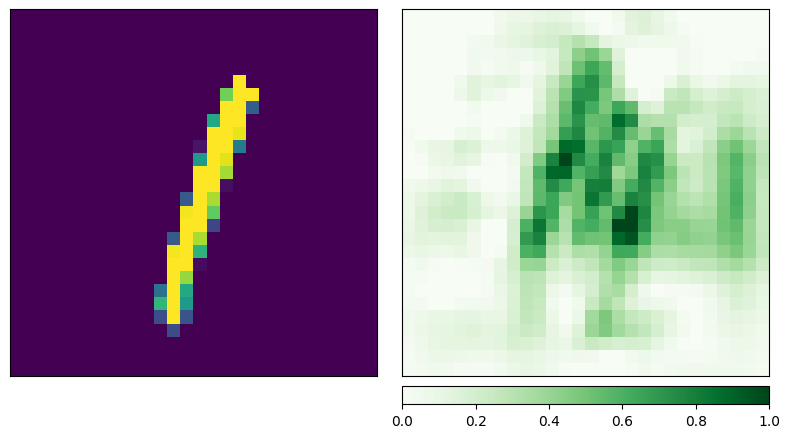

<Figure size 640x480 with 0 Axes>

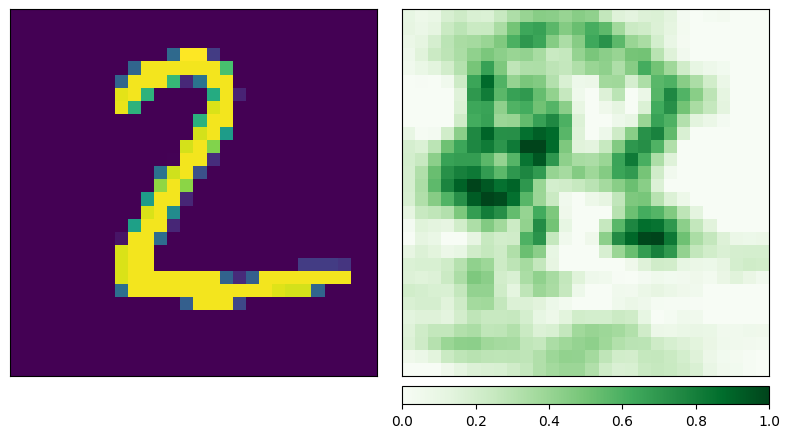

<Figure size 640x480 with 0 Axes>

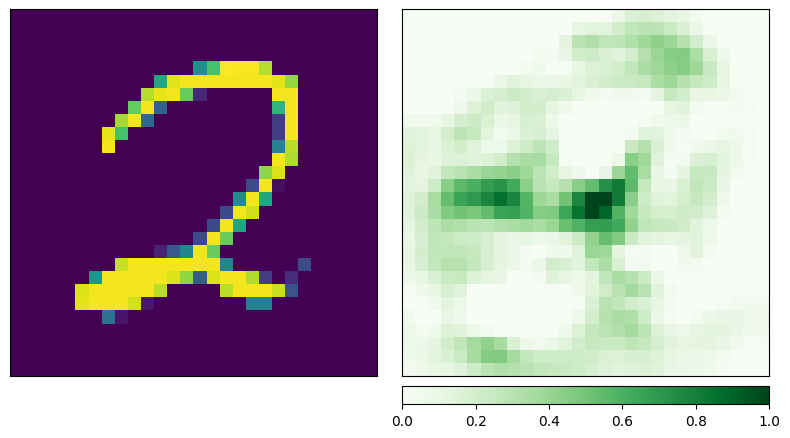

<Figure size 640x480 with 0 Axes>

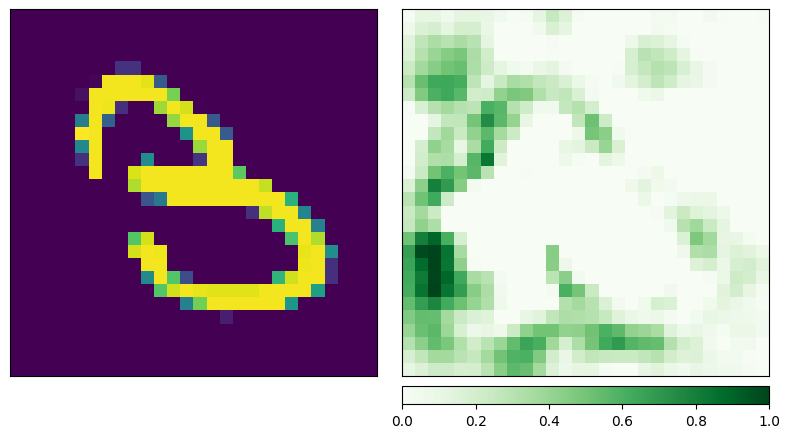

<Figure size 640x480 with 0 Axes>

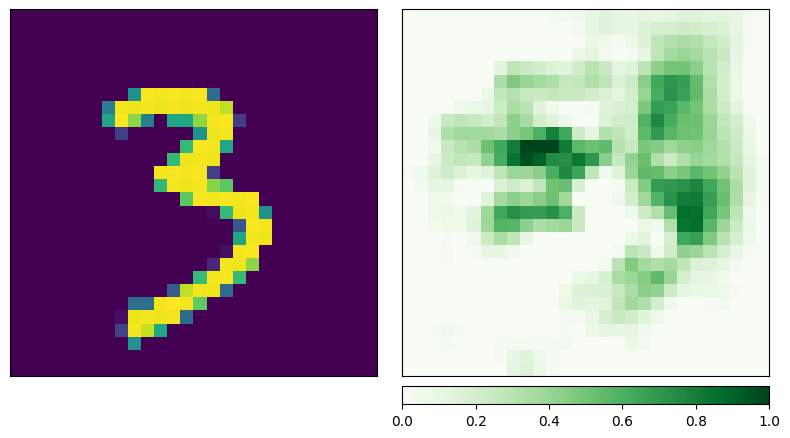

<Figure size 640x480 with 0 Axes>

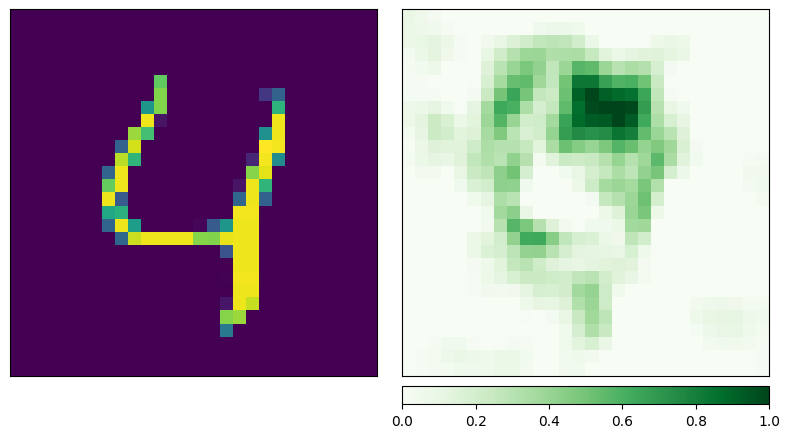

<Figure size 640x480 with 0 Axes>

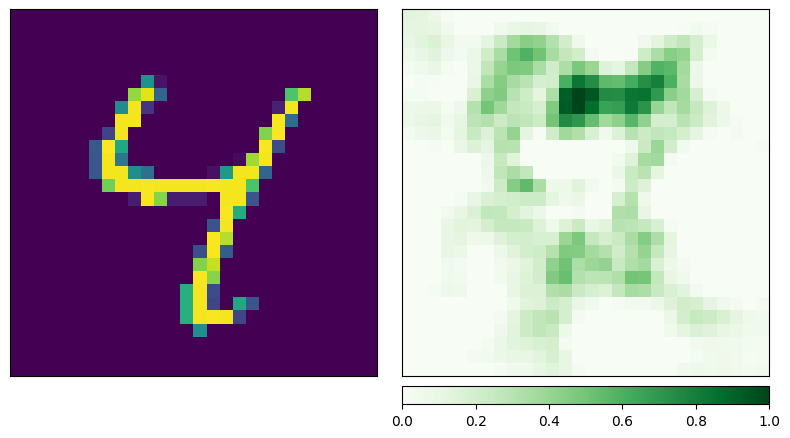

<Figure size 640x480 with 0 Axes>

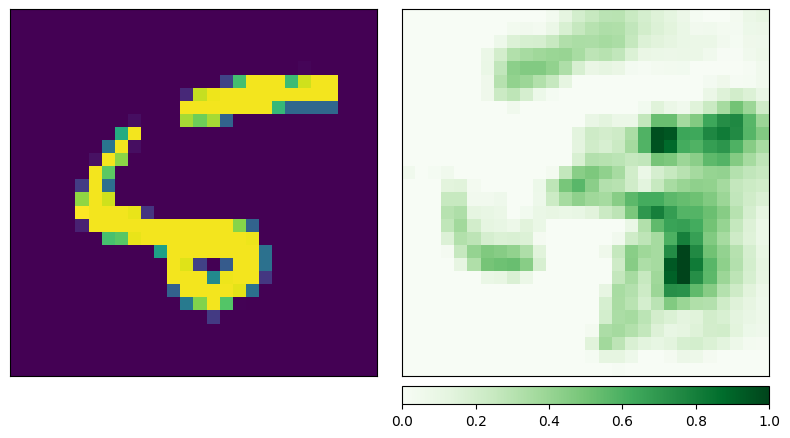

<Figure size 640x480 with 0 Axes>

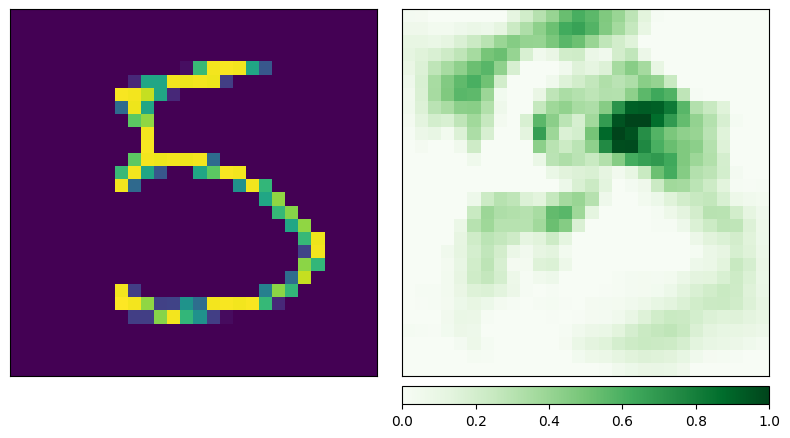

<Figure size 640x480 with 0 Axes>

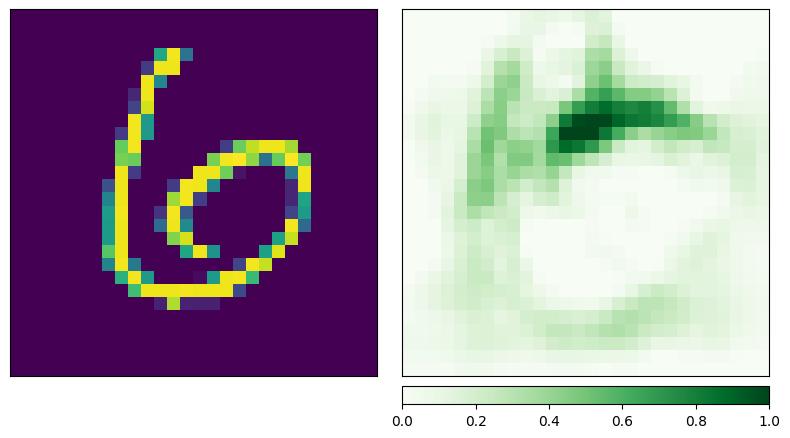

<Figure size 640x480 with 0 Axes>

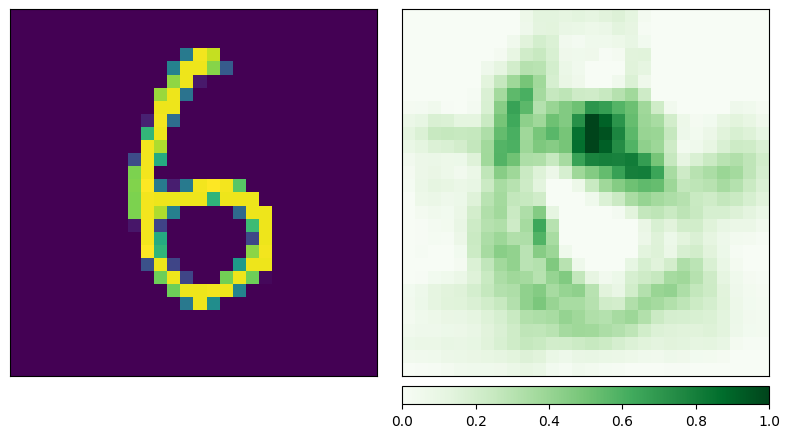

<Figure size 640x480 with 0 Axes>

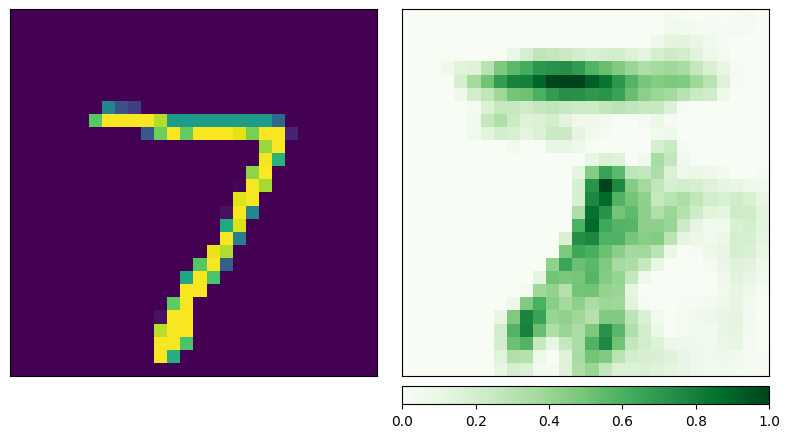

<Figure size 640x480 with 0 Axes>

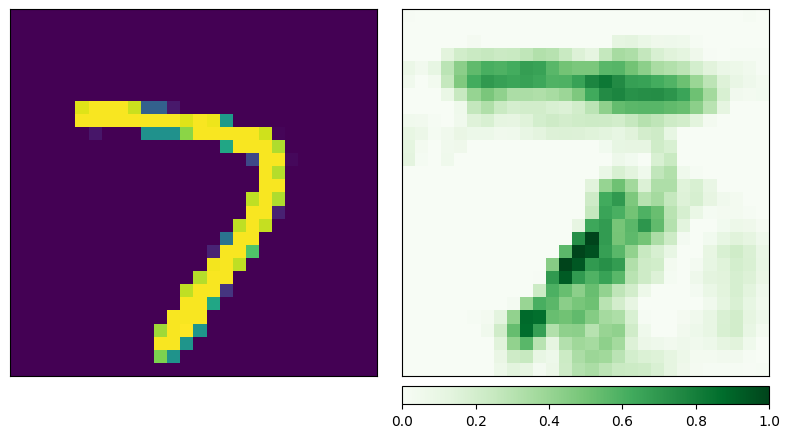

<Figure size 640x480 with 0 Axes>

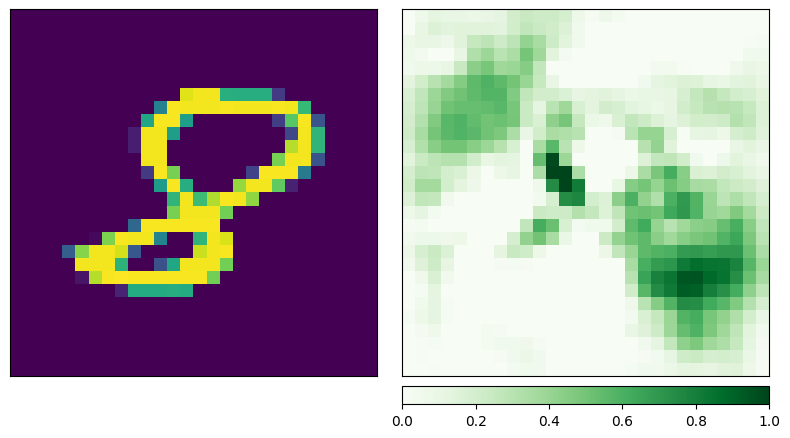

<Figure size 640x480 with 0 Axes>

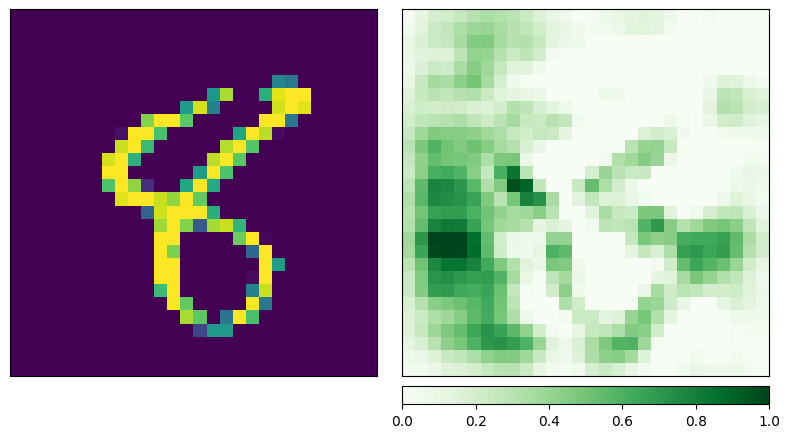

<Figure size 640x480 with 0 Axes>

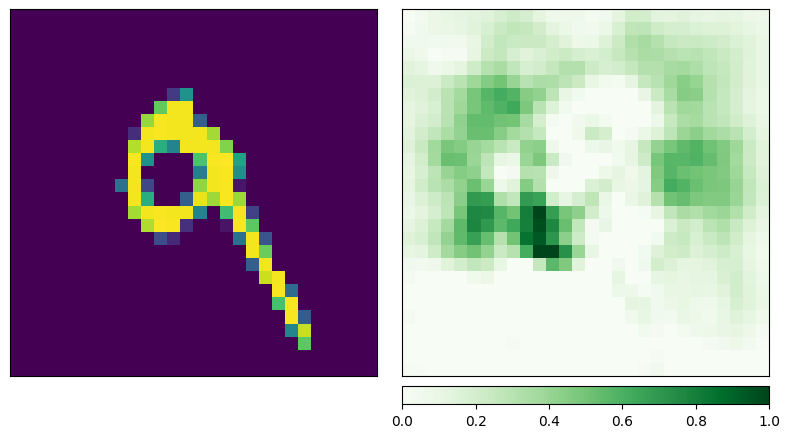

<Figure size 640x480 with 0 Axes>

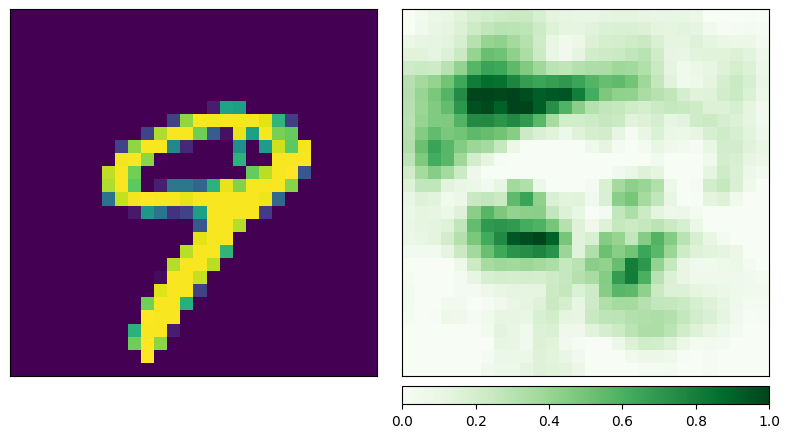

<Figure size 640x480 with 0 Axes>

In [ ]:
# Loop through each selected image
for image, predicted_label in zip(selected_images_list, predicted_labels):

    # Generate attributions using Occlusion
    input_img = image.unsqueeze(0)  # Add batch dimension
    attributions_occ = occlusion.attribute(input_img,
                                           strides=(1, 1, 1),
                                           target=predicted_label,
                                           sliding_window_shapes=(1, 2, 2),
                                           baselines=0)

    # Prepare the reshaped attribution and image for visualization
    attr_reshaped = attributions_occ.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    
    # Visualize the original image and the attribution side by side
    _ = viz.visualize_image_attr_multiple(attr_reshaped,
                                          img_reshaped,
                                          ["original_image", "heat_map"],
                                          ["all", "positive"],
                                          show_colorbar=True,
                                          outlier_perc=2)
    plt.tight_layout()
    plt.show()